# Демонстрация процесса обучения модели на примере классификации

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Импорт необходимых библиотек для анализа
import pandas as pd
import numpy as np
from scipy.stats import skew, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Импорт необходимых библиотек для схемы обучения и проверки
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GroupKFold, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, f1_score

# Импорт необходимых алгоритмов для обучения
import lightgbm as lgb
import xgboost as xgb
import catboost as catb

In [3]:
# Определение пути разработанной библиотеки
import sys
sys.path.append('../')

In [4]:
# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, PermutationSelection, base_pipe, StratifiedGroupKFold, AutoTrees, AutoSelection, BalanceCover, PlotShap, PlotPDP

## Начало анализа

In [5]:
sample = pd.read_csv('./data/train_titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare Cabin Embarked  
0      0  A/5 21171   7.2500   NaN        S  
1      0   PC 17599  71.2833   C85        C

In [6]:
# Анализ пропущенных значений.
## Удаляются факторы с пропусками более 95

check_nans = pd.DataFrame(sample.isna().sum()).rename(columns={0:'Nans'}).sort_values(by='Nans',ascending=False)
check_nans['Nans_percent'] = (check_nans.Nans/len(sample))*100
print('Размер выборки: ', sample.shape)

drop_columns = list(check_nans[check_nans.Nans_percent>95].index)
print('Количество признаков с пропусками >95%: ', len(drop_columns))
check_nans[check_nans.Nans_percent>95]

Размер выборки:  (891, 12)
Количество признаков с пропусками >95%:  0


Empty DataFrame
Columns: [Nans, Nans_percent]
Index: []

In [7]:
# Удаление из выборки факторов с пропусками более 95%

sample = sample.drop(columns=drop_columns)
print('Shape after drop factors with Nans > 95 percent: ', sample.shape)

Shape after drop factors with Nans > 95 percent:  (891, 12)


In [8]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

features = num_columns + cat_columns

target = ['Survived']

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [10]:
# Разделение тренировочной выборки на подмножества для расчета Permutation Importance 

folds_perm = list(StratifiedKFold(n_splits=4,
                                  shuffle=True,
                                  random_state=42).split(X_train,y_train))

df_train_perm = X_train.iloc[folds_perm[3][0]]
print('Train permutation: ', df_train_perm.shape, ';','Target rate: ',  df_train_perm[target].mean())

df_test_perm = X_train.iloc[folds_perm[3][1]]
print('Test permutation: ', df_test_perm.shape, ';','Target rate: ', df_test_perm[target].mean())

# Трансформация категориальных и числовых признаков для корреляционного анализа и Permutation Importance

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns, 
    kind='all')

prep_pipe.fit(df_train_perm[features], df_train_perm[target])

X_train_perm = prep_pipe.transform(df_train_perm[features])
y_train_perm = df_train_perm[target]

X_test_perm = prep_pipe.transform(df_test_perm[features])
y_test_perm = df_test_perm[target]

Train permutation:  (468, 12) ; Target rate:  Survived    0.384615
dtype: float64
Test permutation:  (155, 12) ; Target rate:  Survived    0.380645
dtype: float64


In [11]:
# Определение стандартных гиперпараметров моделей и список моделей

params_lgb = {
    'learning_rate':0.01,
    'n_estimators':500,
    'subsample':0.9,
    'max_depth':6,
    'objective':'binary',
    'metric':'roc_auc',
    'n_jobs':-1,
    'random_state':42,
    'verbose':-1,
    'force_col_wise':True}

model = 'lightboost'

In [12]:
# Инициализация класса Permutation Importance

perm_imp = PermutationSelection(
    model_type=model, 
    model_params=params_lgb, 
    task_type='classification')

In [13]:
# Анализ значимости признаков по глубине обучения алгоритма (глубина меняется от 1 до max_depth). Отбираются только те, у кого средняя значимость > 0.

fi, fi_rank, depth_features, rank_features = perm_imp.depth_analysis(
    X_train=X_train_perm, 
    y_train=y_train_perm, 
    features=features, 
    max_depth=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Количество признаков до отбора: 7
Количество признаков после mean importance относительно глубины: 7
Количество признаков после mean rank относительно глубины: 7


In [14]:
fi

importance_depth_1  importance_depth_2  importance_depth_3  \
Sex              7222.068954         7624.775904         7792.491137   
Fare              882.117600         1237.138001         2290.703269   
Age                98.007571         1135.480372         1997.947886   
Pclass           1143.905361         1704.762598         1649.672314   
Parch              57.982180          240.768719          460.865883   
SibSp               0.000000          215.701041          430.118079   
Embarked           82.458840          188.313283          327.366432   

          importance_depth_4  importance_depth_5  mean_importance  mean_rank  
Sex              7828.070124         7855.061333      7664.493490   0.257143  
Fare             2634.510324         3074.197157      2023.733270   0.202381  
Age              2381.535845         2798.012823      1682.196899   0.164286  
Pclass           1741.995858         1906.308021      1629.328830   0.176190  
Parch             502.381049          452.610760       342.921718   0.080952  
SibSp             478.591781          494.870007       323.856182   0.064286  
Embarked          454.961549          490.789362       308.777893   0.054762

In [15]:
fi_rank

rank_depth_1  rank_depth_2  rank_depth_3  rank_depth_4  \
index                                                              
Sex           0.285714      0.250000      0.250000      0.250000   
Fare          0.190476      0.178571      0.214286      0.214286   
Pclass        0.238095      0.214286      0.142857      0.142857   
Age           0.142857      0.142857      0.178571      0.178571   
Parch         0.047619      0.107143      0.107143      0.107143   
SibSp         0.000000      0.071429      0.071429      0.071429   
Embarked      0.095238      0.035714      0.035714      0.035714   

          rank_depth_5  mean_rank  
index                              
Sex           0.250000   0.257143  
Fare          0.214286   0.202381  
Pclass        0.142857   0.176190  
Age           0.178571   0.164286  
Parch         0.035714   0.080952  
SibSp         0.107143   0.064286  
Embarked      0.071429   0.054762

In [16]:
depth_features

['Age', 'Fare', 'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']

In [17]:
rank_features

['Age', 'Fare', 'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']

In [18]:
# Обновляем факторы

features = list(filter(lambda x: x in features, rank_features))
num_columns = list(filter(lambda x: x in features, num_columns))
cat_columns = list(filter(lambda x: x in features, cat_columns))

print(len(features),len(num_columns),len(cat_columns))

7 2 5


In [19]:
# Обновляем трансформацию факторов

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns, 
    kind='all')

prep_pipe.fit(df_train_perm[features], df_train_perm[target])

X_train_perm = prep_pipe.transform(df_train_perm[features])
X_test_perm = prep_pipe.transform(df_test_perm[features])

In [20]:
%%time

# Обучаем Permutation Importance

perm_imp.fit(
    X_train=X_train_perm,
    y_train=y_train_perm)

# Рассчитываем метрики для каждого фактора

perm_table = perm_imp.calculate_permutation(
    X_test=X_test_perm, 
    y_test=y_test_perm,
    n_iter=15,
    permute_type='sklearn',
    n_jobs=-1,
#   metric=roc_auc_score,
#   higher_is_better=True
)

CPU times: user 1.3 s, sys: 208 ms, total: 1.51 s
Wall time: 3.97 s


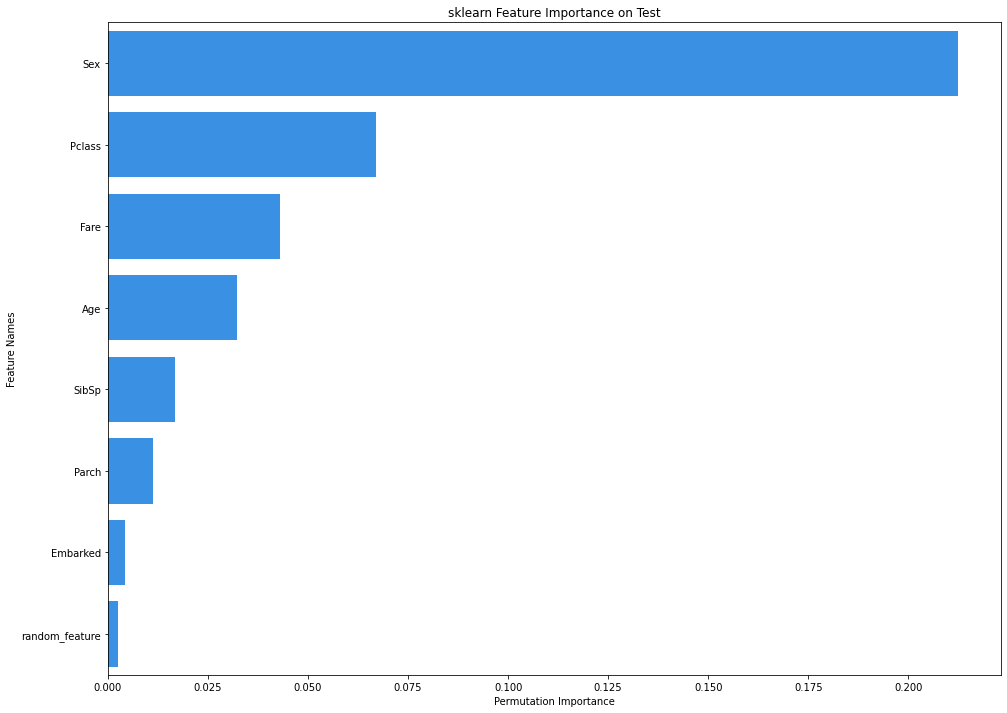

In [21]:
# Отрисовка топ факторов по Permutation Importance

perm_imp.permutation_plot(figsize=(16,12), top=10)

In [22]:
# Обновляем признаки

features = perm_imp.select_features()
num_columns = list(filter(lambda x: x in features, num_columns))
cat_columns = list(filter(lambda x: x in features, cat_columns))

print(len(features),len(num_columns),len(cat_columns))

8 признаков было до Permutation Importance 

7 признаков после Permutation Importance от sklearn
7 2 5


In [23]:
features

['Sex', 'Pclass', 'Fare', 'Age', 'SibSp', 'Parch', 'Embarked']

## Расчет важностей по кросс-валидации

In [24]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns, 
    kind='all')

In [25]:
params = {
    'learning_rate':0.01,
    'n_estimators':1000,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'max_depth':6,
    'objective':'binary',
    'n_jobs':-1,
    'random_state':42,
#    'eval_metric':'auc'
}

fit_params = {
    'early_stopping_rounds':100, 
    'eval_metric':['logloss', 'auc'],
    'verbose':25}

# создаем экземпляр класса LightGBM
lgb_model = lgb.LGBMClassifier(**params)

# задаем стратегию проверки
strat = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

In [26]:
model = AutoTrees(
    main_estimator=lgb_model, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    main_metric='roc_auc',
    model_type = 'lightboost')

In [27]:
model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.588642	training's auc: 0.91409	valid_1's binary_logloss: 0.610696	valid_1's auc: 0.802895
[50]	training's binary_logloss: 0.532684	training's auc: 0.920656	valid_1's binary_logloss: 0.575504	valid_1's auc: 0.797754
[75]	training's binary_logloss: 0.49109	training's auc: 0.925098	valid_1's binary_logloss: 0.551861	valid_1's auc: 0.797348
[100]	training's binary_logloss: 0.457261	training's auc: 0.926292	valid_1's binary_logloss: 0.532354	valid_1's auc: 0.796807
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.593081	training's auc: 0.914158	valid_1's binary_logloss: 0.613733	valid_1's auc: 0.80506
BEST ITERATION:  23


1it [00:00,  4.38it/s]

roc_auc на обучающей выборке: 0.914
roc_auc на проверочной выборке: 0.805

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.591783	training's auc: 0.902809	valid_1's binary_logloss: 0.608713	valid_1's auc: 0.834821
[50]	training's binary_logloss: 0.537394	training's auc: 0.911788	valid_1's binary_logloss: 0.57351	valid_1's auc: 0.842127
[75]	training's binary_logloss: 0.497967	training's auc: 0.915727	valid_1's binary_logloss: 0.547875	valid_1's auc: 0.83888
[100]	training's binary_logloss: 0.465347	training's auc: 0.918226	valid_1's binary_logloss: 0.527354	valid_1's auc: 0.837527


2it [00:00,  3.92it/s]

[125]	training's binary_logloss: 0.43893	training's auc: 0.92179	valid_1's binary_logloss: 0.51161	valid_1's auc: 0.836986
[150]	training's binary_logloss: 0.416476	training's auc: 0.923726	valid_1's binary_logloss: 0.498366	valid_1's auc: 0.835904
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.532322	training's auc: 0.911737	valid_1's binary_logloss: 0.569071	valid_1's auc: 0.84375
BEST ITERATION:  53
roc_auc на обучающей выборке: 0.912
roc_auc на проверочной выборке: 0.844

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  3.49it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.590874	training's auc: 0.907089	valid_1's binary_logloss: 0.607255	valid_1's auc: 0.832792
[50]	training's binary_logloss: 0.536839	training's auc: 0.917501	valid_1's binary_logloss: 0.5676	valid_1's auc: 0.837662
[75]	training's binary_logloss: 0.497226	training's auc: 0.920588	valid_1's binary_logloss: 0.541407	valid_1's auc: 0.840097
[100]	training's binary_logloss: 0.464638	training's auc: 0.923095	valid_1's binary_logloss: 0.519547	valid_1's auc: 0.841721
[125]	training's binary_logloss: 0.437008	training's auc: 0.926582	valid_1's binary_logloss: 0.502793	valid_1's auc: 0.844156
[150]	training's binary_logloss: 0.413718	training's auc: 0.928927	valid_1's binary_logloss: 0.488873	valid_1's auc: 0.843344
[175]	training's binary_logloss: 0.397217	training's auc: 0.931511	valid_1's binary_logloss: 0.481675	valid_1's auc: 0.844697
[200]	training's binary_logloss: 0.382244	training's auc: 0.9

4it [00:01,  3.14it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.596843	training's auc: 0.896427	valid_1's binary_logloss: 0.590901	valid_1's auc: 0.903012
[50]	training's binary_logloss: 0.546825	training's auc: 0.903103	valid_1's binary_logloss: 0.544019	valid_1's auc: 0.89638
[75]	training's binary_logloss: 0.508287	training's auc: 0.907777	valid_1's binary_logloss: 0.507389	valid_1's auc: 0.898867
[100]	training's binary_logloss: 0.477417	training's auc: 0.910491	valid_1's binary_logloss: 0.475957	valid_1's auc: 0.90163
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.599318	training's auc: 0.896783	valid_1's binary_logloss: 0.593735	valid_1's auc: 0.903565
BEST ITERATION:  24
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.904

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  3.15it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.59341	training's auc: 0.89618	valid_1's binary_logloss: 0.600969	valid_1's auc: 0.886787
[50]	training's binary_logloss: 0.542555	training's auc: 0.902648	valid_1's binary_logloss: 0.549854	valid_1's auc: 0.897889
[75]	training's binary_logloss: 0.504149	training's auc: 0.907051	valid_1's binary_logloss: 0.51374	valid_1's auc: 0.897889
[100]	training's binary_logloss: 0.473525	training's auc: 0.909329	valid_1's binary_logloss: 0.485864	valid_1's auc: 0.898986
[125]	training's binary_logloss: 0.447654	training's auc: 0.913358	valid_1's binary_logloss: 0.465684	valid_1's auc: 0.89597
[150]	training's binary_logloss: 0.426024	training's auc: 0.915567	valid_1's binary_logloss: 0.448073	valid_1's auc: 0.897067
[175]	training's binary_logloss: 0.410509	training's auc: 0.917658	valid_1's binary_logloss: 0.435644	valid_1's auc: 0.899534
[200]	training's binary_logloss: 0.396831	training's auc: 0.920

In [28]:
model.get_mean_cv_scores()

0.8600273122966993

In [29]:
model._best_iters

[23, 53, 192, 24, 170]

In [30]:
model.get_extra_scores()

names     fold_1     fold_2     fold_3     fold_4     fold_5
0   roc_train   0.914158   0.911737   0.933301   0.896783   0.916859
1   roc_valid   0.805060   0.843750   0.847132   0.903565   0.900630
2  gini_train  82.831659  82.347323  86.660300  79.356678  83.371864
3  gini_valid  61.011905  68.750000  69.426407  80.712904  80.126096

In [31]:
fi = model.get_fi()
fi

index  importance 0  importance 1  importance 2  importance 3  \
0       Sex   2305.140991   3484.923218   6755.695194   1952.906609   
1      Fare    476.183954   1333.267428   3069.212963    483.133051   
2    Pclass    318.580008    977.403624   1602.951751    314.214110   
3       Age    338.310433    475.163332   1478.903913    275.340546   
4     Parch     52.331021    179.306130    461.834366     41.119885   
5  Embarked     99.877195    132.939483    385.555584    106.615582   
6     SibSp     47.592102     95.978042    191.893973    188.405216   

   importance 4  mean_importance  
0   6309.483284      4161.629859  
1   2266.145046      1525.588488  
2   1353.914980       913.412894  
3   1688.856389       851.314923  
4    448.219842       236.562249  
5    297.732096       204.543988  
6    258.012599       156.376386

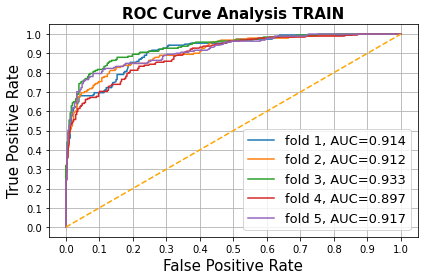

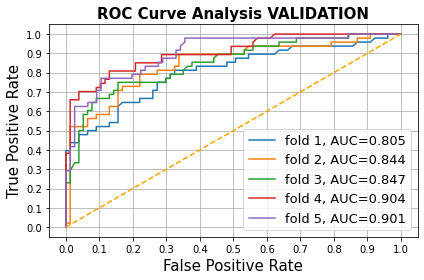

In [32]:
model.get_rocauc_plots()

In [33]:
model.get_curve_plots()

## Жадные отборы Forward и Backward selection

In [34]:
selection = AutoSelection(base_pipe=base_pipe,
                          num_columns=num_columns,
                          cat_columns=cat_columns,
                          main_fit_params=fit_params,
                          main_estimator=lgb_model,
                          
                          X_train=X_train,
                          y_train=y_train,
                          main_metric='roc_auc',
                          model_type='lightboost')

In [35]:
fselection_res = selection.forward_selection(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.588642	training's auc: 0.91409	valid_1's binary_logloss: 0.610696	valid_1's auc: 0.802895
[50]	training's binary_logloss: 0.532684	training's auc: 0.920656	valid_1's binary_logloss: 0.575504	valid_1's auc: 0.797754


1it [00:00,  3.26it/s]

[75]	training's binary_logloss: 0.49109	training's auc: 0.925098	valid_1's binary_logloss: 0.551861	valid_1's auc: 0.797348
[100]	training's binary_logloss: 0.457261	training's auc: 0.926292	valid_1's binary_logloss: 0.532354	valid_1's auc: 0.796807
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.593081	training's auc: 0.914158	valid_1's binary_logloss: 0.613733	valid_1's auc: 0.80506
BEST ITERATION:  23
roc_auc на обучающей выборке: 0.914
roc_auc на проверочной выборке: 0.805

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  3.12it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.591783	training's auc: 0.902809	valid_1's binary_logloss: 0.608713	valid_1's auc: 0.834821
[50]	training's binary_logloss: 0.537394	training's auc: 0.911788	valid_1's binary_logloss: 0.57351	valid_1's auc: 0.842127
[75]	training's binary_logloss: 0.497967	training's auc: 0.915727	valid_1's binary_logloss: 0.547875	valid_1's auc: 0.83888
[100]	training's binary_logloss: 0.465347	training's auc: 0.918226	valid_1's binary_logloss: 0.527354	valid_1's auc: 0.837527
[125]	training's binary_logloss: 0.43893	training's auc: 0.92179	valid_1's binary_logloss: 0.51161	valid_1's auc: 0.836986
[150]	training's binary_logloss: 0.416476	training's auc: 0.923726	valid_1's binary_logloss: 0.498366	valid_1's auc: 0.835904
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.532322	training's auc: 0.911737	valid_1's binary_logloss: 0.569071	valid_1's auc: 0.84375
BEST ITERATION:  53
roc_auc на 

3it [00:01,  2.58it/s]

[225]	training's binary_logloss: 0.368769	training's auc: 0.938025	valid_1's binary_logloss: 0.471928	valid_1's auc: 0.844697
[250]	training's binary_logloss: 0.359245	training's auc: 0.93968	valid_1's binary_logloss: 0.469308	valid_1's auc: 0.84118
[275]	training's binary_logloss: 0.3484	training's auc: 0.942187	valid_1's binary_logloss: 0.464462	valid_1's auc: 0.842262
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.387126	training's auc: 0.933301	valid_1's binary_logloss: 0.477485	valid_1's auc: 0.847132
BEST ITERATION:  192
roc_auc на обучающей выборке: 0.933
roc_auc на проверочной выборке: 0.847

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:01,  2.87it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.596843	training's auc: 0.896427	valid_1's binary_logloss: 0.590901	valid_1's auc: 0.903012
[50]	training's binary_logloss: 0.546825	training's auc: 0.903103	valid_1's binary_logloss: 0.544019	valid_1's auc: 0.89638
[75]	training's binary_logloss: 0.508287	training's auc: 0.907777	valid_1's binary_logloss: 0.507389	valid_1's auc: 0.898867
[100]	training's binary_logloss: 0.477417	training's auc: 0.910491	valid_1's binary_logloss: 0.475957	valid_1's auc: 0.90163
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.599318	training's auc: 0.896783	valid_1's binary_logloss: 0.593735	valid_1's auc: 0.903565
BEST ITERATION:  24
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.904

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 10

5it [00:02,  2.50it/s]


[200]	training's binary_logloss: 0.396831	training's auc: 0.920089	valid_1's binary_logloss: 0.425406	valid_1's auc: 0.898986
[225]	training's binary_logloss: 0.383668	training's auc: 0.921891	valid_1's binary_logloss: 0.416324	valid_1's auc: 0.899808
[250]	training's binary_logloss: 0.374122	training's auc: 0.92371	valid_1's binary_logloss: 0.410047	valid_1's auc: 0.89926
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.413713	training's auc: 0.916859	valid_1's binary_logloss: 0.438139	valid_1's auc: 0.90063
BEST ITERATION:  170
roc_auc на обучающей выборке: 0.917
roc_auc на проверочной выборке: 0.901

********************** 5 фолд обучен! ******************************


Средняя метрика на фолдах со всеми факторами:  0.860027
Конец обуения кросс-валидации!

Начало жадного отбора факторов Forward Selection!
Добавление признака Sex


1it [00:00,  6.48it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.602265	training's auc: 0.779764	valid_1's binary_logloss: 0.613851	valid_1's auc: 0.734578
[50]	training's binary_logloss: 0.563651	training's auc: 0.779764	valid_1's binary_logloss: 0.58394	valid_1's auc: 0.734578
[75]	training's binary_logloss: 0.539579	training's auc: 0.779764	valid_1's binary_logloss: 0.566737	valid_1's auc: 0.734578
[100]	training's binary_logloss: 0.524431	training's auc: 0.779764	valid_1's binary_logloss: 0.557081	valid_1's auc: 0.734578
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.662536	training's auc: 0.779764	valid_1's binary_logloss: 0.663281	valid_1's auc: 0.734578
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.780
roc_auc на проверочной выборке: 0.735

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ===============

2it [00:00,  6.69it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.607059	training's auc: 0.768653	valid_1's binary_logloss: 0.604705	valid_1's auc: 0.778815
[50]	training's binary_logloss: 0.571424	training's auc: 0.768653	valid_1's binary_logloss: 0.567001	valid_1's auc: 0.778815
[75]	training's binary_logloss: 0.549282	training's auc: 0.768653	valid_1's binary_logloss: 0.54317	valid_1's auc: 0.778815
[100]	training's binary_logloss: 0.5354	training's auc: 0.768653	valid_1's binary_logloss: 0.527906	valid_1's auc: 0.778815
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.66278	training's auc: 0.768653	valid_1's binary_logloss: 0.662886	valid_1's auc: 0.778815
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.769
roc_auc на проверочной выборке: 0.779

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 ro

4it [00:00,  6.58it/s]

roc_auc на обучающей выборке: 0.776
roc_auc на проверочной выборке: 0.749

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.612717	training's auc: 0.756786	valid_1's binary_logloss: 0.59383	valid_1's auc: 0.826886
[50]	training's binary_logloss: 0.580202	training's auc: 0.756786	valid_1's binary_logloss: 0.548518	valid_1's auc: 0.826886
[75]	training's binary_logloss: 0.560061	training's auc: 0.756786	valid_1's binary_logloss: 0.518094	valid_1's auc: 0.826886
[100]	training's binary_logloss: 0.547483	training's auc: 0.756786	valid_1's binary_logloss: 0.497208	valid_1's auc: 0.826886
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.663623	training's auc: 0.756786	valid_1's binary_logloss: 0.660199	valid_1's auc: 0.826886
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.757
roc_auc на проверо

5it [00:00,  7.13it/s]


Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.604862	training's auc: 0.772132	valid_1's binary_logloss: 0.608652	valid_1's auc: 0.764803
[50]	training's binary_logloss: 0.568122	training's auc: 0.772132	valid_1's binary_logloss: 0.573518	valid_1's auc: 0.764803
[75]	training's binary_logloss: 0.545269	training's auc: 0.772132	valid_1's binary_logloss: 0.552096	valid_1's auc: 0.764803
[100]	training's binary_logloss: 0.53092	training's auc: 0.772132	valid_1's binary_logloss: 0.538988	valid_1's auc: 0.764803
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.662319	training's auc: 0.772132	valid_1's binary_logloss: 0.664458	valid_1's auc: 0.764803
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.772
roc_auc на проверочной выборке: 0.765

********************** 5 фолд обучен! ******************************


Количество признаков: 1 => метрика: 0.7707998235433846
Добавление признака Fare


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.623581	training's auc: 0.76722	valid_1's binary_logloss: 0.63328	valid_1's auc: 0.694535
[50]	training's binary_logloss: 0.597213	training's auc: 0.769292	valid_1's binary_logloss: 0.617562	valid_1's auc: 0.693182
[75]	training's binary_logloss: 0.579409	training's auc: 0.772055	valid_1's binary_logloss: 0.610059	valid_1's auc: 0.695076
[100]	training's binary_logloss: 0.56654	training's auc: 0.773155	valid_1's binary_logloss: 0.602957	valid_1's auc: 0.69697
[125]	training's binary_logloss: 0.557909	training's auc: 0.776447	valid_1's binary_logloss: 0.600315	valid_1's auc: 0.696293
[150]	training's binary_logloss: 0.551422	training's auc: 0.778996	valid_1's binary_logloss: 0.59936	valid_1's auc: 0.700622
[175]	training's binary_logloss: 0.546347	training's auc: 0.78505	valid_1's binary_logloss: 0.599163	valid_1's auc: 0.708198
[200]

1it [00:00,  4.11it/s]

roc_auc на обучающей выборке: 0.793
roc_auc на проверочной выборке: 0.718

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.622054	training's auc: 0.774502	valid_1's binary_logloss: 0.645127	valid_1's auc: 0.663826
[50]	training's binary_logloss: 0.594269	training's auc: 0.777393	valid_1's binary_logloss: 0.633564	valid_1's auc: 0.663149
[75]	training's binary_logloss: 0.575094	training's auc: 0.779431	valid_1's binary_logloss: 0.625791	valid_1's auc: 0.668831
[100]	training's binary_logloss: 0.562537	training's auc: 0.784402	valid_1's binary_logloss: 0.623908	valid_1's auc: 0.678571
[125]	training's binary_logloss: 0.552901	training's auc: 0.789595	valid_1's binary_logloss: 0.624041	valid_1's auc: 0.6829
[150]	training's binary_logloss: 0.545163	training's auc: 0.793415	valid_1's binary_logloss: 0.625688	valid

2it [00:00,  5.18it/s]

BEST ITERATION:  118
roc_auc на обучающей выборке: 0.786
roc_auc на проверочной выборке: 0.686

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  5.83it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.620912	training's auc: 0.774485	valid_1's binary_logloss: 0.65277	valid_1's auc: 0.619183
[50]	training's binary_logloss: 0.593341	training's auc: 0.776822	valid_1's binary_logloss: 0.645761	valid_1's auc: 0.631223
[75]	training's binary_logloss: 0.575655	training's auc: 0.780727	valid_1's binary_logloss: 0.641503	valid_1's auc: 0.637581
[100]	training's binary_logloss: 0.563927	training's auc: 0.783012	valid_1's binary_logloss: 0.640467	valid_1's auc: 0.639746
[125]	training's binary_logloss: 0.555715	training's auc: 0.783737	valid_1's binary_logloss: 0.640446	valid_1's auc: 0.646916
[150]	training's binary_logloss: 0.549698	training's auc: 0.784871	valid_1's binary_logloss: 0.641088	valid_1's auc: 0.64651
[175]	training's binary_logloss: 0.545114	training's auc: 0.788299	valid_1's binary_logloss: 0.643068	valid_1's auc: 0.650298
[200]	training's binary_logloss: 0.541277	training's auc: 0.7

4it [00:00,  6.39it/s]

roc_auc на обучающей выборке: 0.763
roc_auc на проверочной выборке: 0.776

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.624625	training's auc: 0.760114	valid_1's binary_logloss: 0.630849	valid_1's auc: 0.700795
[50]	training's binary_logloss: 0.599137	training's auc: 0.764457	valid_1's binary_logloss: 0.608654	valid_1's auc: 0.700521
[75]	training's binary_logloss: 0.582625	training's auc: 0.767084	valid_1's binary_logloss: 0.597976	valid_1's auc: 0.704084
[100]	training's binary_logloss: 0.571664	training's auc: 0.768954	valid_1's binary_logloss: 0.591061	valid_1's auc: 0.71176
[125]	training's binary_logloss: 0.56404	training's auc: 0.773169	valid_1's binary_logloss: 0.584844	valid_1's auc: 0.729989
[150]	training's binary_logloss: 0.558452	training's auc: 0.774283	valid_1's binary_logloss: 0.581772	valid

5it [00:00,  5.38it/s]


BEST ITERATION:  375
roc_auc на обучающей выборке: 0.784
roc_auc на проверочной выборке: 0.751

********************** 5 фолд обучен! ******************************


Количество признаков: 2 => метрика: 0.7152469089794118
Добавление признака Pclass


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.616824	training's auc: 0.791036	valid_1's binary_logloss: 0.634004	valid_1's auc: 0.683577
[50]	training's binary_logloss: 0.58588	training's auc: 0.793245	valid_1's binary_logloss: 0.618475	valid_1's auc: 0.682089
[75]	training's binary_logloss: 0.56575	training's auc: 0.793586	valid_1's binary_logloss: 0.612646	valid_1's auc: 0.682089
[100]	training's binary_logloss: 0.552248	training's auc: 0.796801	valid_1's binary_logloss: 0.612588	valid_1's auc: 0.683306
[125]	training's binary_logloss: 0.541699	training's auc: 0.808244	valid_1's binary_logloss: 0.611383	valid_1's auc: 0.691017
[150]	training's binary_logloss: 0.530871	training's auc: 0.811407	valid_1's binary_logloss: 0.612438	valid_1's auc: 0.678707
[175]	training's binary_logloss: 0.523173	training's auc: 0.816038	valid_1's binary_logloss: 0.61654	valid_1's auc: 0.68006
[20

1it [00:00,  4.89it/s]

Early stopping, best iteration is:
[120]	training's binary_logloss: 0.543605	training's auc: 0.808397	valid_1's binary_logloss: 0.611738	valid_1's auc: 0.693723
BEST ITERATION:  120
roc_auc на обучающей выборке: 0.808
roc_auc на проверочной выборке: 0.694

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.614621	training's auc: 0.803818	valid_1's binary_logloss: 0.646203	valid_1's auc: 0.654627
[50]	training's binary_logloss: 0.581703	training's auc: 0.808901	valid_1's binary_logloss: 0.636181	valid_1's auc: 0.671943
[75]	training's binary_logloss: 0.559152	training's auc: 0.809745	valid_1's binary_logloss: 0.631884	valid_1's auc: 0.674378
[100]	training's binary_logloss: 0.543292	training's auc: 0.815918	valid_1's binary_logloss: 0.629926	valid_1's auc: 0.679248
[125]	training's binary_logloss: 0.530231	trainin

2it [00:00,  4.89it/s]

BEST ITERATION:  159
roc_auc на обучающей выборке: 0.822
roc_auc на проверочной выборке: 0.688

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.617635	training's auc: 0.789936	valid_1's binary_logloss: 0.641134	valid_1's auc: 0.68033
[50]	training's binary_logloss: 0.587405	training's auc: 0.791036	valid_1's binary_logloss: 0.627018	valid_1's auc: 0.680195
[75]	training's binary_logloss: 0.567351	training's auc: 0.795334	valid_1's binary_logloss: 0.619504	valid_1's auc: 0.696834
[100]	training's binary_logloss: 0.553996	training's auc: 0.797994	valid_1's binary_logloss: 0.617071	valid_1's auc: 0.692776
[125]	training's binary_logloss: 0.544512	training's auc: 0.799026	valid_1's binary_logloss: 0.616966	valid_1's auc: 0.694805
[150]	training's binary_logloss: 0.537096	training's auc: 0.804032	valid_1's binary_l

3it [00:00,  4.16it/s]

roc_auc на обучающей выборке: 0.817
roc_auc на проверочной выборке: 0.712

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.6217	training's auc: 0.775075	valid_1's binary_logloss: 0.627032	valid_1's auc: 0.719812
[50]	training's binary_logloss: 0.593667	training's auc: 0.775075	valid_1's binary_logloss: 0.605745	valid_1's auc: 0.719812
[75]	training's binary_logloss: 0.576112	training's auc: 0.781369	valid_1's binary_logloss: 0.59414	valid_1's auc: 0.73045
[100]	training's binary_logloss: 0.564319	training's auc: 0.784541	valid_1's binary_logloss: 0.586145	valid_1's auc: 0.742747
[125]	training's binary_logloss: 0.554833	training's auc: 0.78941	valid_1's binary_logloss: 0.581697	valid_1's auc: 0.744405
[150]	training's binary_logloss: 0.546852	training's auc: 0.792549	valid_1's binary_logloss: 0.576556	valid_1'

4it [00:00,  3.95it/s]

[400]	training's binary_logloss: 0.514885	training's auc: 0.814315	valid_1's binary_logloss: 0.56275	valid_1's auc: 0.756286
[425]	training's binary_logloss: 0.513112	training's auc: 0.815622	valid_1's binary_logloss: 0.562008	valid_1's auc: 0.757115
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.519105	training's auc: 0.809955	valid_1's binary_logloss: 0.563662	valid_1's auc: 0.758911
BEST ITERATION:  340
roc_auc на обучающей выборке: 0.810
roc_auc на проверочной выборке: 0.759

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.622019	training's auc: 0.774657	valid_1's binary_logloss: 0.62091	valid_1's auc: 0.768503
[50]	training's binary_logloss: 0.594548	training's auc: 0.776696	valid_1's binary_logloss: 0.59307	valid_1's auc: 0.763569
[75]	training's binary_logloss: 0.577445	training's

5it [00:01,  4.19it/s]


[200]	training's binary_logloss: 0.535795	training's auc: 0.799934	valid_1's binary_logloss: 0.54923	valid_1's auc: 0.789474
[225]	training's binary_logloss: 0.531777	training's auc: 0.801574	valid_1's binary_logloss: 0.546889	valid_1's auc: 0.789748
[250]	training's binary_logloss: 0.528455	training's auc: 0.803486	valid_1's binary_logloss: 0.545774	valid_1's auc: 0.78824
[275]	training's binary_logloss: 0.525425	training's auc: 0.806368	valid_1's binary_logloss: 0.544497	valid_1's auc: 0.788788
[300]	training's binary_logloss: 0.523212	training's auc: 0.808578	valid_1's binary_logloss: 0.542395	valid_1's auc: 0.784951
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.534761	training's auc: 0.800444	valid_1's binary_logloss: 0.548481	valid_1's auc: 0.791118
BEST ITERATION:  206
roc_auc на обучающей выборке: 0.800
roc_auc на проверочной выборке: 0.791

********************** 5 фолд обучен! ******************************


Количество признаков: 3 => метрика: 0.728701

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.605666	training's auc: 0.893531	valid_1's binary_logloss: 0.63974	valid_1's auc: 0.700622
[50]	training's binary_logloss: 0.557037	training's auc: 0.906527	valid_1's binary_logloss: 0.613817	valid_1's auc: 0.739583
[75]	training's binary_logloss: 0.522353	training's auc: 0.908147	valid_1's binary_logloss: 0.599179	valid_1's auc: 0.736607
[100]	training's binary_logloss: 0.4933	training's auc: 0.911259	valid_1's binary_logloss: 0.586371	valid_1's auc: 0.747294
[125]	training's binary_logloss: 0.467969	training's auc: 0.916316	valid_1's binary_logloss: 0.570841	valid_1's auc: 0.758793
[150]	training's binary_logloss: 0.445706	training's auc: 0.919906	valid_1's binary_logloss: 0.559656	valid_1's auc: 0.762716
[175]	training's binary_logloss: 0.428794	training's auc: 0.922464	valid_1's binary_logloss: 0.552325	valid_1's auc: 0.765693
[2

1it [00:00,  2.97it/s]

roc_auc на обучающей выборке: 0.938
roc_auc на проверочной выборке: 0.794

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.610879	training's auc: 0.887358	valid_1's binary_logloss: 0.629693	valid_1's auc: 0.791937
[50]	training's binary_logloss: 0.565716	training's auc: 0.897957	valid_1's binary_logloss: 0.601666	valid_1's auc: 0.800054
[75]	training's binary_logloss: 0.532619	training's auc: 0.902127	valid_1's binary_logloss: 0.583328	valid_1's auc: 0.800054
[100]	training's binary_logloss: 0.504781	training's auc: 0.905068	valid_1's binary_logloss: 0.56716	valid_1's auc: 0.803166
[125]	training's binary_logloss: 0.481381	training's auc: 0.909187	valid_1's binary_logloss: 0.554125	valid_1's auc: 0.801948
[150]	training's binary_logloss: 0.460856	training's auc: 0.912061	valid_1's binary_logloss: 0.543239	vali

2it [00:00,  3.74it/s]

roc_auc на обучающей выборке: 0.916
roc_auc на проверочной выборке: 0.816

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  4.61it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.610916	training's auc: 0.881073	valid_1's binary_logloss: 0.6232	valid_1's auc: 0.828328
[50]	training's binary_logloss: 0.566162	training's auc: 0.9002	valid_1's binary_logloss: 0.594141	valid_1's auc: 0.815476
[75]	training's binary_logloss: 0.532663	training's auc: 0.902775	valid_1's binary_logloss: 0.573547	valid_1's auc: 0.810877
[100]	training's binary_logloss: 0.503503	training's auc: 0.90801	valid_1's binary_logloss: 0.554372	valid_1's auc: 0.812906
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.656901	training's auc: 0.875761	valid_1's binary_logloss: 0.658229	valid_1's auc: 0.849297
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.876
roc_auc на проверочной выборке: 0.849

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rou

4it [00:01,  4.06it/s]

roc_auc на обучающей выборке: 0.906
roc_auc на проверочной выборке: 0.910

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  4.23it/s]


Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.613661	training's auc: 0.874303	valid_1's binary_logloss: 0.618067	valid_1's auc: 0.861157
[50]	training's binary_logloss: 0.569453	training's auc: 0.889211	valid_1's binary_logloss: 0.58021	valid_1's auc: 0.860334
[75]	training's binary_logloss: 0.537638	training's auc: 0.892364	valid_1's binary_logloss: 0.55304	valid_1's auc: 0.859512
[100]	training's binary_logloss: 0.510664	training's auc: 0.897064	valid_1's binary_logloss: 0.52916	valid_1's auc: 0.856223
[125]	training's binary_logloss: 0.487787	training's auc: 0.901085	valid_1's binary_logloss: 0.50977	valid_1's auc: 0.862802
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.599357	training's auc: 0.879403	valid_1's binary_logloss: 0.605311	valid_1's auc: 0.86801
BEST ITERATION:  34
roc_auc на обучающей выборке: 0.879
roc_auc на проверочной выборке: 0.868

********************** 5 фолд обучен! ***********************

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  5.34it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.590041	training's auc: 0.922327	valid_1's binary_logloss: 0.617492	valid_1's auc: 0.785579
[50]	training's binary_logloss: 0.532956	training's auc: 0.925789	valid_1's binary_logloss: 0.582446	valid_1's auc: 0.791802
[75]	training's binary_logloss: 0.491844	training's auc: 0.92845	valid_1's binary_logloss: 0.5589	valid_1's auc: 0.791531
[100]	training's binary_logloss: 0.457966	training's auc: 0.929703	valid_1's binary_logloss: 0.54187	valid_1's auc: 0.791802
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.661027	training's auc: 0.885644	valid_1's binary_logloss: 0.662406	valid_1's auc: 0.808442
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.886
roc_auc на проверочной выборке: 0.808

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 ro

2it [00:00,  4.96it/s]

[75]	training's binary_logloss: 0.498683	training's auc: 0.917688	valid_1's binary_logloss: 0.554867	valid_1's auc: 0.821834
[100]	training's binary_logloss: 0.465843	training's auc: 0.921125	valid_1's binary_logloss: 0.532769	valid_1's auc: 0.827516
[125]	training's binary_logloss: 0.441773	training's auc: 0.923026	valid_1's binary_logloss: 0.521365	valid_1's auc: 0.82454
[150]	training's binary_logloss: 0.421064	training's auc: 0.925627	valid_1's binary_logloss: 0.512334	valid_1's auc: 0.822781
[175]	training's binary_logloss: 0.404111	training's auc: 0.928134	valid_1's binary_logloss: 0.505837	valid_1's auc: 0.821699
[200]	training's binary_logloss: 0.390513	training's auc: 0.930999	valid_1's binary_logloss: 0.503113	valid_1's auc: 0.81994
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.465843	training's auc: 0.921125	valid_1's binary_logloss: 0.532769	valid_1's auc: 0.827516
BEST ITERATION:  100
roc_auc на обучающей выборке: 0.921
roc_auc на проверочной выборк

3it [00:00,  4.70it/s]

[50]	training's binary_logloss: 0.537663	training's auc: 0.922566	valid_1's binary_logloss: 0.572239	valid_1's auc: 0.833469
[75]	training's binary_logloss: 0.496686	training's auc: 0.926821	valid_1's binary_logloss: 0.545583	valid_1's auc: 0.832927
[100]	training's binary_logloss: 0.462753	training's auc: 0.93065	valid_1's binary_logloss: 0.521462	valid_1's auc: 0.839827
[125]	training's binary_logloss: 0.437688	training's auc: 0.933174	valid_1's binary_logloss: 0.507248	valid_1's auc: 0.840909
[150]	training's binary_logloss: 0.416742	training's auc: 0.935604	valid_1's binary_logloss: 0.498174	valid_1's auc: 0.837256
[175]	training's binary_logloss: 0.399467	training's auc: 0.938008	valid_1's binary_logloss: 0.490857	valid_1's auc: 0.833198
[200]	training's binary_logloss: 0.386119	training's auc: 0.940336	valid_1's binary_logloss: 0.488232	valid_1's auc: 0.829951
[225]	training's binary_logloss: 0.372733	training's auc: 0.941777	valid_1's binary_logloss: 0.482553	valid_1's auc: 0.83

4it [00:00,  5.00it/s]

[25]	training's binary_logloss: 0.60022	training's auc: 0.898497	valid_1's binary_logloss: 0.592594	valid_1's auc: 0.908262
[50]	training's binary_logloss: 0.550301	training's auc: 0.902891	valid_1's binary_logloss: 0.540678	valid_1's auc: 0.909091
[75]	training's binary_logloss: 0.512704	training's auc: 0.906479	valid_1's binary_logloss: 0.503824	valid_1's auc: 0.908538
[100]	training's binary_logloss: 0.481574	training's auc: 0.909448	valid_1's binary_logloss: 0.471786	valid_1's auc: 0.910196
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.627469	training's auc: 0.895189	valid_1's binary_logloss: 0.62114	valid_1's auc: 0.912683
BEST ITERATION:  14
roc_auc на обучающей выборке: 0.895
roc_auc на проверочной выборке: 0.913

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.597708	training's a

5it [00:01,  4.96it/s]

[50]	training's binary_logloss: 0.545656	training's auc: 0.904221	valid_1's binary_logloss: 0.550656	valid_1's auc: 0.908032
[75]	training's binary_logloss: 0.507124	training's auc: 0.907782	valid_1's binary_logloss: 0.514421	valid_1's auc: 0.909677
[100]	training's binary_logloss: 0.475308	training's auc: 0.911709	valid_1's binary_logloss: 0.484247	valid_1's auc: 0.911458
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.647486	training's auc: 0.877414	valid_1's binary_logloss: 0.647311	valid_1's auc: 0.925164
BEST ITERATION:  6
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.925

********************** 5 фолд обучен! ******************************


Количество признаков: 5 => метрика: 0.8632675590087405

Количество отобранных признаков: 5
Метрика до отбора: 0.86 => после отбора: 0.8633
Конец жадного отбора факторов Forward Selection!


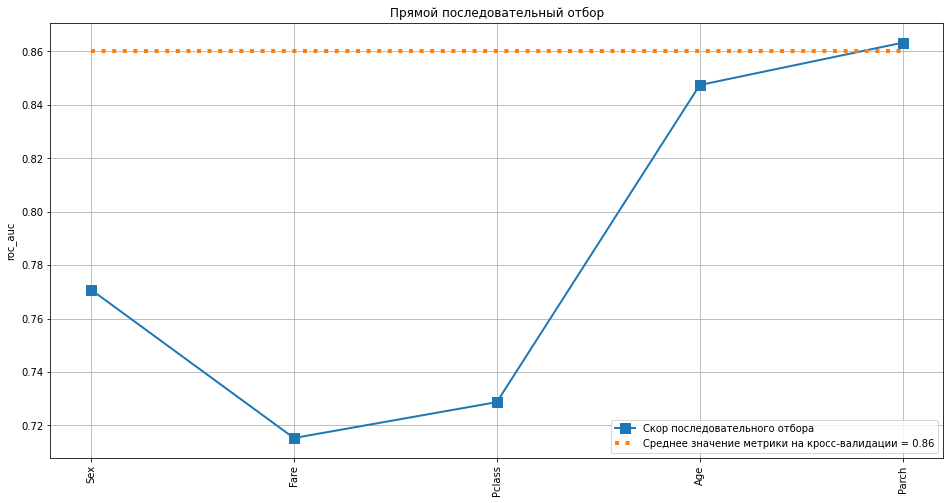

In [36]:
selection.plot_forward(figsize=(16,8))

In [37]:
bselection_res = selection.backward_selection(strat=strat,first_degradation=True)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.588642	training's auc: 0.91409	valid_1's binary_logloss: 0.610696	valid_1's auc: 0.802895
[50]	training's binary_logloss: 0.532684	training's auc: 0.920656	valid_1's binary_logloss: 0.575504	valid_1's auc: 0.797754
[75]	training's binary_logloss: 0.49109	training's auc: 0.925098	valid_1's binary_logloss: 0.551861	valid_1's auc: 0.797348
[100]	training's binary_logloss: 0.457261	training's auc: 0.926292	valid_1's binary_logloss: 0.532354	valid_1's auc: 0.796807
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.593081	training's auc: 0.914158	valid_1's binary_logloss: 0.613733	valid_1's auc: 0.80506
BEST ITERATION:  23


1it [00:00,  4.75it/s]

roc_auc на обучающей выборке: 0.914
roc_auc на проверочной выборке: 0.805

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.591783	training's auc: 0.902809	valid_1's binary_logloss: 0.608713	valid_1's auc: 0.834821
[50]	training's binary_logloss: 0.537394	training's auc: 0.911788	valid_1's binary_logloss: 0.57351	valid_1's auc: 0.842127


2it [00:00,  3.97it/s]

[75]	training's binary_logloss: 0.497967	training's auc: 0.915727	valid_1's binary_logloss: 0.547875	valid_1's auc: 0.83888
[100]	training's binary_logloss: 0.465347	training's auc: 0.918226	valid_1's binary_logloss: 0.527354	valid_1's auc: 0.837527
[125]	training's binary_logloss: 0.43893	training's auc: 0.92179	valid_1's binary_logloss: 0.51161	valid_1's auc: 0.836986
[150]	training's binary_logloss: 0.416476	training's auc: 0.923726	valid_1's binary_logloss: 0.498366	valid_1's auc: 0.835904
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.532322	training's auc: 0.911737	valid_1's binary_logloss: 0.569071	valid_1's auc: 0.84375
BEST ITERATION:  53
roc_auc на обучающей выборке: 0.912
roc_auc на проверочной выборке: 0.844

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  3.54it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.590874	training's auc: 0.907089	valid_1's binary_logloss: 0.607255	valid_1's auc: 0.832792
[50]	training's binary_logloss: 0.536839	training's auc: 0.917501	valid_1's binary_logloss: 0.5676	valid_1's auc: 0.837662
[75]	training's binary_logloss: 0.497226	training's auc: 0.920588	valid_1's binary_logloss: 0.541407	valid_1's auc: 0.840097
[100]	training's binary_logloss: 0.464638	training's auc: 0.923095	valid_1's binary_logloss: 0.519547	valid_1's auc: 0.841721
[125]	training's binary_logloss: 0.437008	training's auc: 0.926582	valid_1's binary_logloss: 0.502793	valid_1's auc: 0.844156
[150]	training's binary_logloss: 0.413718	training's auc: 0.928927	valid_1's binary_logloss: 0.488873	valid_1's auc: 0.843344
[175]	training's binary_logloss: 0.397217	training's auc: 0.931511	valid_1's binary_logloss: 0.481675	valid_1's auc: 0.844697
[200]	training's binary_logloss: 0.382244	training's auc: 0.9

4it [00:01,  3.81it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.596843	training's auc: 0.896427	valid_1's binary_logloss: 0.590901	valid_1's auc: 0.903012
[50]	training's binary_logloss: 0.546825	training's auc: 0.903103	valid_1's binary_logloss: 0.544019	valid_1's auc: 0.89638
[75]	training's binary_logloss: 0.508287	training's auc: 0.907777	valid_1's binary_logloss: 0.507389	valid_1's auc: 0.898867
[100]	training's binary_logloss: 0.477417	training's auc: 0.910491	valid_1's binary_logloss: 0.475957	valid_1's auc: 0.90163
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.599318	training's auc: 0.896783	valid_1's binary_logloss: 0.593735	valid_1's auc: 0.903565
BEST ITERATION:  24
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.904

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  3.70it/s]


Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.59341	training's auc: 0.89618	valid_1's binary_logloss: 0.600969	valid_1's auc: 0.886787
[50]	training's binary_logloss: 0.542555	training's auc: 0.902648	valid_1's binary_logloss: 0.549854	valid_1's auc: 0.897889
[75]	training's binary_logloss: 0.504149	training's auc: 0.907051	valid_1's binary_logloss: 0.51374	valid_1's auc: 0.897889
[100]	training's binary_logloss: 0.473525	training's auc: 0.909329	valid_1's binary_logloss: 0.485864	valid_1's auc: 0.898986
[125]	training's binary_logloss: 0.447654	training's auc: 0.913358	valid_1's binary_logloss: 0.465684	valid_1's auc: 0.89597
[150]	training's binary_logloss: 0.426024	training's auc: 0.915567	valid_1's binary_logloss: 0.448073	valid_1's auc: 0.897067
[175]	training's binary_logloss: 0.410509	training's auc: 0.917658	valid_1's binary_logloss: 0.435644	valid_1's auc: 0.899534
[200]	training's binary_logloss: 0.396831	training's auc: 0.920

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.58068	training's auc: 0.918831	valid_1's binary_logloss: 0.607473	valid_1's auc: 0.797348
[50]	training's binary_logloss: 0.52092	training's auc: 0.921909	valid_1's binary_logloss: 0.568697	valid_1's auc: 0.793425
[75]	training's binary_logloss: 0.480688	training's auc: 0.924118	valid_1's binary_logloss: 0.54646	valid_1's auc: 0.797213


1it [00:00,  4.28it/s]

[100]	training's binary_logloss: 0.449283	training's auc: 0.925815	valid_1's binary_logloss: 0.533253	valid_1's auc: 0.79586
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.652709	training's auc: 0.896422	valid_1's binary_logloss: 0.655763	valid_1's auc: 0.804654
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.896
roc_auc на проверочной выборке: 0.805

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.583216	training's auc: 0.910125	valid_1's binary_logloss: 0.603037	valid_1's auc: 0.825622
[50]	training's binary_logloss: 0.526109	training's auc: 0.911779	valid_1's binary_logloss: 0.561586	valid_1's auc: 0.83171
[75]	training's binary_logloss: 0.487183	training's auc: 0.914951	valid_1's binary_logloss: 0.536632	valid_1's auc: 0.834686
[100]	training's binary_logloss: 0.45707	training's auc

2it [00:00,  4.74it/s]

roc_auc на обучающей выборке: 0.884
roc_auc на проверочной выборке: 0.837

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.582468	training's auc: 0.915386	valid_1's binary_logloss: 0.600395	valid_1's auc: 0.837662
[50]	training's binary_logloss: 0.524758	training's auc: 0.918038	valid_1's binary_logloss: 0.557876	valid_1's auc: 0.837933
[75]	training's binary_logloss: 0.48629	training's auc: 0.920929	valid_1's binary_logloss: 0.533191	valid_1's auc: 0.839827
[100]	training's binary_logloss: 0.455031	training's auc: 0.925661	valid_1's binary_logloss: 0.512404	valid_1's auc: 0.845103
[125]	training's binary_logloss: 0.428365	training's auc: 0.928722	valid_1's binary_logloss: 0.496603	valid_1's auc: 0.84862
[150]	training's binary_logloss: 0.406456	training's auc: 0.931136	valid_1's binary_logloss: 0.486165	valid

3it [00:00,  4.28it/s]

[200]	training's binary_logloss: 0.374715	training's auc: 0.936678	valid_1's binary_logloss: 0.473853	valid_1's auc: 0.844697
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.438147	training's auc: 0.927563	valid_1's binary_logloss: 0.501369	valid_1's auc: 0.849432
BEST ITERATION:  115
roc_auc на обучающей выборке: 0.928
roc_auc на проверочной выборке: 0.849

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.590023	training's auc: 0.898734	valid_1's binary_logloss: 0.585119	valid_1's auc: 0.883117
[50]	training's binary_logloss: 0.536935	training's auc: 0.901466	valid_1's binary_logloss: 0.530537	valid_1's auc: 0.889887


4it [00:00,  4.50it/s]

[75]	training's binary_logloss: 0.500051	training's auc: 0.904587	valid_1's binary_logloss: 0.494965	valid_1's auc: 0.89265
[100]	training's binary_logloss: 0.471405	training's auc: 0.906564	valid_1's binary_logloss: 0.468859	valid_1's auc: 0.89265
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.652434	training's auc: 0.893798	valid_1's binary_logloss: 0.648141	valid_1's auc: 0.903703
BEST ITERATION:  4
roc_auc на обучающей выборке: 0.894
roc_auc на проверочной выборке: 0.904

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds


5it [00:01,  4.36it/s]


[25]	training's binary_logloss: 0.586932	training's auc: 0.903048	valid_1's binary_logloss: 0.589669	valid_1's auc: 0.899397
[50]	training's binary_logloss: 0.531923	training's auc: 0.904629	valid_1's binary_logloss: 0.536686	valid_1's auc: 0.901042
[75]	training's binary_logloss: 0.494344	training's auc: 0.907909	valid_1's binary_logloss: 0.500616	valid_1's auc: 0.903509
[100]	training's binary_logloss: 0.465172	training's auc: 0.911649	valid_1's binary_logloss: 0.473265	valid_1's auc: 0.905428
[125]	training's binary_logloss: 0.441213	training's auc: 0.914191	valid_1's binary_logloss: 0.453712	valid_1's auc: 0.904057
[150]	training's binary_logloss: 0.420819	training's auc: 0.916817	valid_1's binary_logloss: 0.437099	valid_1's auc: 0.905976
[175]	training's binary_logloss: 0.403986	training's auc: 0.919146	valid_1's binary_logloss: 0.427649	valid_1's auc: 0.902961
[200]	training's binary_logloss: 0.391205	training's auc: 0.920523	valid_1's binary_logloss: 0.418148	valid_1's auc: 0.90

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  5.99it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.590041	training's auc: 0.922327	valid_1's binary_logloss: 0.617492	valid_1's auc: 0.785579
[50]	training's binary_logloss: 0.532956	training's auc: 0.925789	valid_1's binary_logloss: 0.582446	valid_1's auc: 0.791802
[75]	training's binary_logloss: 0.491844	training's auc: 0.92845	valid_1's binary_logloss: 0.5589	valid_1's auc: 0.791531
[100]	training's binary_logloss: 0.457966	training's auc: 0.929703	valid_1's binary_logloss: 0.54187	valid_1's auc: 0.791802
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.661027	training's auc: 0.885644	valid_1's binary_logloss: 0.662406	valid_1's auc: 0.808442
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.886
roc_auc на проверочной выборке: 0.808

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 ro

2it [00:00,  5.22it/s]

[125]	training's binary_logloss: 0.441773	training's auc: 0.923026	valid_1's binary_logloss: 0.521365	valid_1's auc: 0.82454
[150]	training's binary_logloss: 0.421064	training's auc: 0.925627	valid_1's binary_logloss: 0.512334	valid_1's auc: 0.822781
[175]	training's binary_logloss: 0.404111	training's auc: 0.928134	valid_1's binary_logloss: 0.505837	valid_1's auc: 0.821699
[200]	training's binary_logloss: 0.390513	training's auc: 0.930999	valid_1's binary_logloss: 0.503113	valid_1's auc: 0.81994
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.465843	training's auc: 0.921125	valid_1's binary_logloss: 0.532769	valid_1's auc: 0.827516
BEST ITERATION:  100
roc_auc на обучающей выборке: 0.921
roc_auc на проверочной выборке: 0.828

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.593087	trainin

3it [00:00,  4.87it/s]

[125]	training's binary_logloss: 0.437688	training's auc: 0.933174	valid_1's binary_logloss: 0.507248	valid_1's auc: 0.840909
[150]	training's binary_logloss: 0.416742	training's auc: 0.935604	valid_1's binary_logloss: 0.498174	valid_1's auc: 0.837256
[175]	training's binary_logloss: 0.399467	training's auc: 0.938008	valid_1's binary_logloss: 0.490857	valid_1's auc: 0.833198
[200]	training's binary_logloss: 0.386119	training's auc: 0.940336	valid_1's binary_logloss: 0.488232	valid_1's auc: 0.829951
[225]	training's binary_logloss: 0.372733	training's auc: 0.941777	valid_1's binary_logloss: 0.482553	valid_1's auc: 0.831304
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.433175	training's auc: 0.933174	valid_1's binary_logloss: 0.504611	valid_1's auc: 0.842532
BEST ITERATION:  130
roc_auc на обучающей выборке: 0.933
roc_auc на проверочной выборке: 0.843

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ===

4it [00:00,  5.14it/s]

[100]	training's binary_logloss: 0.481574	training's auc: 0.909448	valid_1's binary_logloss: 0.471786	valid_1's auc: 0.910196
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.627469	training's auc: 0.895189	valid_1's binary_logloss: 0.62114	valid_1's auc: 0.912683
BEST ITERATION:  14
roc_auc на обучающей выборке: 0.895
roc_auc на проверочной выборке: 0.913

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.597708	training's auc: 0.899606	valid_1's binary_logloss: 0.599063	valid_1's auc: 0.911047
[50]	training's binary_logloss: 0.545656	training's auc: 0.904221	valid_1's binary_logloss: 0.550656	valid_1's auc: 0.908032
[75]	training's binary_logloss: 0.507124	training's auc: 0.907782	valid_1's binary_logloss: 0.514421	valid_1's auc: 0.909677
[100]	training's binary_logloss: 0.475308	training's

5it [00:00,  5.33it/s]


Early stopping, best iteration is:
[6]	training's binary_logloss: 0.647486	training's auc: 0.877414	valid_1's binary_logloss: 0.647311	valid_1's auc: 0.925164
BEST ITERATION:  6
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.925

********************** 5 фолд обучен! ******************************


Количество признаков: 5 => метрика: 0.8632675590087405
Удаление признака 2


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.605666	training's auc: 0.893531	valid_1's binary_logloss: 0.63974	valid_1's auc: 0.700622
[50]	training's binary_logloss: 0.557037	training's auc: 0.906527	valid_1's binary_logloss: 0.613817	valid_1's auc: 0.739583
[75]	training's binary_logloss: 0.522353	training's auc: 0.908147	valid_1's binary_logloss: 0.599179	valid_1's auc: 0.736607
[100]	training's binary_logloss: 0.4933	training's auc: 0.911259	valid_1's binary_logloss: 0.586371	valid_1's auc: 0.747294
[125]	training's binary_logloss: 0.467969	training's auc: 0.916316	valid_1's binary_logloss: 0.570841	valid_1's auc: 0.758793
[150]	training's binary_logloss: 0.445706	training's auc: 0.919906	valid_1's binary_logloss: 0.559656	valid_1's auc: 0.762716
[175]	training's binary_logloss: 0.428794	training's auc: 0.922464	valid_1's binary_logloss: 0.552325	valid_1's auc: 0.765693
[2

1it [00:00,  3.18it/s]

[375]	training's binary_logloss: 0.352839	training's auc: 0.934981	valid_1's binary_logloss: 0.528181	valid_1's auc: 0.792208
[400]	training's binary_logloss: 0.346757	training's auc: 0.936619	valid_1's binary_logloss: 0.526657	valid_1's auc: 0.79329
[425]	training's binary_logloss: 0.341145	training's auc: 0.938929	valid_1's binary_logloss: 0.526513	valid_1's auc: 0.793019
[450]	training's binary_logloss: 0.335624	training's auc: 0.94072	valid_1's binary_logloss: 0.525412	valid_1's auc: 0.792749
[475]	training's binary_logloss: 0.331329	training's auc: 0.941982	valid_1's binary_logloss: 0.524161	valid_1's auc: 0.793831
[500]	training's binary_logloss: 0.326535	training's auc: 0.943108	valid_1's binary_logloss: 0.52498	valid_1's auc: 0.793831
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.343339	training's auc: 0.938213	valid_1's binary_logloss: 0.526898	valid_1's auc: 0.794372
BEST ITERATION:  415
roc_auc на обучающей выборке: 0.938
roc_auc на проверочной выборк

2it [00:00,  3.85it/s]

[50]	training's binary_logloss: 0.565716	training's auc: 0.897957	valid_1's binary_logloss: 0.601666	valid_1's auc: 0.800054
[75]	training's binary_logloss: 0.532619	training's auc: 0.902127	valid_1's binary_logloss: 0.583328	valid_1's auc: 0.800054
[100]	training's binary_logloss: 0.504781	training's auc: 0.905068	valid_1's binary_logloss: 0.56716	valid_1's auc: 0.803166
[125]	training's binary_logloss: 0.481381	training's auc: 0.909187	valid_1's binary_logloss: 0.554125	valid_1's auc: 0.801948
[150]	training's binary_logloss: 0.460856	training's auc: 0.912061	valid_1's binary_logloss: 0.543239	valid_1's auc: 0.804654
[175]	training's binary_logloss: 0.445068	training's auc: 0.913536	valid_1's binary_logloss: 0.536118	valid_1's auc: 0.807359
[200]	training's binary_logloss: 0.428955	training's auc: 0.915898	valid_1's binary_logloss: 0.52627	valid_1's auc: 0.814665
[225]	training's binary_logloss: 0.416594	training's auc: 0.91791	valid_1's binary_logloss: 0.521653	valid_1's auc: 0.8125

3it [00:00,  4.80it/s]

[25]	training's binary_logloss: 0.610916	training's auc: 0.881073	valid_1's binary_logloss: 0.6232	valid_1's auc: 0.828328
[50]	training's binary_logloss: 0.566162	training's auc: 0.9002	valid_1's binary_logloss: 0.594141	valid_1's auc: 0.815476
[75]	training's binary_logloss: 0.532663	training's auc: 0.902775	valid_1's binary_logloss: 0.573547	valid_1's auc: 0.810877
[100]	training's binary_logloss: 0.503503	training's auc: 0.90801	valid_1's binary_logloss: 0.554372	valid_1's auc: 0.812906
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.656901	training's auc: 0.875761	valid_1's binary_logloss: 0.658229	valid_1's auc: 0.849297
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.876
roc_auc на проверочной выборке: 0.849

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.614757	training's auc: 0

4it [00:00,  4.52it/s]

[225]	training's binary_logloss: 0.437729	training's auc: 0.903451	valid_1's binary_logloss: 0.431171	valid_1's auc: 0.907709
[250]	training's binary_logloss: 0.429028	training's auc: 0.905453	valid_1's binary_logloss: 0.423376	valid_1's auc: 0.908262
[275]	training's binary_logloss: 0.421845	training's auc: 0.906742	valid_1's binary_logloss: 0.417145	valid_1's auc: 0.907986
[300]	training's binary_logloss: 0.413814	training's auc: 0.909041	valid_1's binary_logloss: 0.41149	valid_1's auc: 0.908815
[325]	training's binary_logloss: 0.407231	training's auc: 0.910457	valid_1's binary_logloss: 0.406923	valid_1's auc: 0.90688
[350]	training's binary_logloss: 0.401223	training's auc: 0.911916	valid_1's binary_logloss: 0.403554	valid_1's auc: 0.905775
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.428167	training's auc: 0.905504	valid_1's binary_logloss: 0.422766	valid_1's auc: 0.909644
BEST ITERATION:  254
roc_auc на обучающей выборке: 0.906
roc_auc на проверочной выбор

5it [00:01,  4.62it/s]

[125]	training's binary_logloss: 0.487787	training's auc: 0.901085	valid_1's binary_logloss: 0.50977	valid_1's auc: 0.862802
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.599357	training's auc: 0.879403	valid_1's binary_logloss: 0.605311	valid_1's auc: 0.86801
BEST ITERATION:  34
roc_auc на обучающей выборке: 0.879
roc_auc на проверочной выборке: 0.868

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 0.8474138001556113

Количество отобранных признаков: 5
Метрика до отбора: 0.86 => после отбора: 0.8633
Конец жадного отбора факторов Backward Selection!


In [38]:
deep_bselection_res = selection.deep_backward_selection(strat=strat,tol=0.0001)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.588642	training's auc: 0.91409	valid_1's binary_logloss: 0.610696	valid_1's auc: 0.802895
[50]	training's binary_logloss: 0.532684	training's auc: 0.920656	valid_1's binary_logloss: 0.575504	valid_1's auc: 0.797754


1it [00:00,  3.65it/s]

[75]	training's binary_logloss: 0.49109	training's auc: 0.925098	valid_1's binary_logloss: 0.551861	valid_1's auc: 0.797348
[100]	training's binary_logloss: 0.457261	training's auc: 0.926292	valid_1's binary_logloss: 0.532354	valid_1's auc: 0.796807
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.593081	training's auc: 0.914158	valid_1's binary_logloss: 0.613733	valid_1's auc: 0.80506
BEST ITERATION:  23
roc_auc на обучающей выборке: 0.914
roc_auc на проверочной выборке: 0.805

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.591783	training's auc: 0.902809	valid_1's binary_logloss: 0.608713	valid_1's auc: 0.834821
[50]	training's binary_logloss: 0.537394	training's auc: 0.911788	valid_1's binary_logloss: 0.57351	valid_1's auc: 0.842127
[75]	training's binary_logloss: 0.497967	training's au

2it [00:00,  2.82it/s]

roc_auc на обучающей выборке: 0.912
roc_auc на проверочной выборке: 0.844

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.590874	training's auc: 0.907089	valid_1's binary_logloss: 0.607255	valid_1's auc: 0.832792
[50]	training's binary_logloss: 0.536839	training's auc: 0.917501	valid_1's binary_logloss: 0.5676	valid_1's auc: 0.837662


3it [00:01,  2.84it/s]

[75]	training's binary_logloss: 0.497226	training's auc: 0.920588	valid_1's binary_logloss: 0.541407	valid_1's auc: 0.840097
[100]	training's binary_logloss: 0.464638	training's auc: 0.923095	valid_1's binary_logloss: 0.519547	valid_1's auc: 0.841721
[125]	training's binary_logloss: 0.437008	training's auc: 0.926582	valid_1's binary_logloss: 0.502793	valid_1's auc: 0.844156
[150]	training's binary_logloss: 0.413718	training's auc: 0.928927	valid_1's binary_logloss: 0.488873	valid_1's auc: 0.843344
[175]	training's binary_logloss: 0.397217	training's auc: 0.931511	valid_1's binary_logloss: 0.481675	valid_1's auc: 0.844697
[200]	training's binary_logloss: 0.382244	training's auc: 0.934751	valid_1's binary_logloss: 0.476942	valid_1's auc: 0.843344
[225]	training's binary_logloss: 0.368769	training's auc: 0.938025	valid_1's binary_logloss: 0.471928	valid_1's auc: 0.844697
[250]	training's binary_logloss: 0.359245	training's auc: 0.93968	valid_1's binary_logloss: 0.469308	valid_1's auc: 0.8

4it [00:01,  3.11it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.596843	training's auc: 0.896427	valid_1's binary_logloss: 0.590901	valid_1's auc: 0.903012
[50]	training's binary_logloss: 0.546825	training's auc: 0.903103	valid_1's binary_logloss: 0.544019	valid_1's auc: 0.89638
[75]	training's binary_logloss: 0.508287	training's auc: 0.907777	valid_1's binary_logloss: 0.507389	valid_1's auc: 0.898867
[100]	training's binary_logloss: 0.477417	training's auc: 0.910491	valid_1's binary_logloss: 0.475957	valid_1's auc: 0.90163
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.599318	training's auc: 0.896783	valid_1's binary_logloss: 0.593735	valid_1's auc: 0.903565
BEST ITERATION:  24
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.904

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  3.04it/s]


Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.59341	training's auc: 0.89618	valid_1's binary_logloss: 0.600969	valid_1's auc: 0.886787
[50]	training's binary_logloss: 0.542555	training's auc: 0.902648	valid_1's binary_logloss: 0.549854	valid_1's auc: 0.897889
[75]	training's binary_logloss: 0.504149	training's auc: 0.907051	valid_1's binary_logloss: 0.51374	valid_1's auc: 0.897889
[100]	training's binary_logloss: 0.473525	training's auc: 0.909329	valid_1's binary_logloss: 0.485864	valid_1's auc: 0.898986
[125]	training's binary_logloss: 0.447654	training's auc: 0.913358	valid_1's binary_logloss: 0.465684	valid_1's auc: 0.89597
[150]	training's binary_logloss: 0.426024	training's auc: 0.915567	valid_1's binary_logloss: 0.448073	valid_1's auc: 0.897067
[175]	training's binary_logloss: 0.410509	training's auc: 0.917658	valid_1's binary_logloss: 0.435644	valid_1's auc: 0.899534
[200]	training's binary_logloss: 0.396831	training's auc: 0.920

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds


1it [00:00,  3.66it/s]

[25]	training's binary_logloss: 0.58068	training's auc: 0.918831	valid_1's binary_logloss: 0.607473	valid_1's auc: 0.797348
[50]	training's binary_logloss: 0.52092	training's auc: 0.921909	valid_1's binary_logloss: 0.568697	valid_1's auc: 0.793425
[75]	training's binary_logloss: 0.480688	training's auc: 0.924118	valid_1's binary_logloss: 0.54646	valid_1's auc: 0.797213
[100]	training's binary_logloss: 0.449283	training's auc: 0.925815	valid_1's binary_logloss: 0.533253	valid_1's auc: 0.79586
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.652709	training's auc: 0.896422	valid_1's binary_logloss: 0.655763	valid_1's auc: 0.804654
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.896
roc_auc на проверочной выборке: 0.805

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.583216	training's auc: 

2it [00:00,  4.32it/s]

[50]	training's binary_logloss: 0.526109	training's auc: 0.911779	valid_1's binary_logloss: 0.561586	valid_1's auc: 0.83171
[75]	training's binary_logloss: 0.487183	training's auc: 0.914951	valid_1's binary_logloss: 0.536632	valid_1's auc: 0.834686
[100]	training's binary_logloss: 0.45707	training's auc: 0.917228	valid_1's binary_logloss: 0.518483	valid_1's auc: 0.835227
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.657115	training's auc: 0.883938	valid_1's binary_logloss: 0.65865	valid_1's auc: 0.837392
BEST ITERATION:  2
roc_auc на обучающей выборке: 0.884
roc_auc на проверочной выборке: 0.837

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.582468	training's auc: 0.915386	valid_1's binary_logloss: 0.600395	valid_1's auc: 0.837662
[50]	training's binary_logloss: 0.524758	training's auc:

3it [00:00,  4.30it/s]

[75]	training's binary_logloss: 0.48629	training's auc: 0.920929	valid_1's binary_logloss: 0.533191	valid_1's auc: 0.839827
[100]	training's binary_logloss: 0.455031	training's auc: 0.925661	valid_1's binary_logloss: 0.512404	valid_1's auc: 0.845103
[125]	training's binary_logloss: 0.428365	training's auc: 0.928722	valid_1's binary_logloss: 0.496603	valid_1's auc: 0.84862
[150]	training's binary_logloss: 0.406456	training's auc: 0.931136	valid_1's binary_logloss: 0.486165	valid_1's auc: 0.844832
[175]	training's binary_logloss: 0.3893	training's auc: 0.933438	valid_1's binary_logloss: 0.479538	valid_1's auc: 0.83915
[200]	training's binary_logloss: 0.374715	training's auc: 0.936678	valid_1's binary_logloss: 0.473853	valid_1's auc: 0.844697
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.438147	training's auc: 0.927563	valid_1's binary_logloss: 0.501369	valid_1's auc: 0.849432
BEST ITERATION:  115
roc_auc на обучающей выборке: 0.928
roc_auc на проверочной выборке: 

4it [00:00,  4.65it/s]

[25]	training's binary_logloss: 0.590023	training's auc: 0.898734	valid_1's binary_logloss: 0.585119	valid_1's auc: 0.883117
[50]	training's binary_logloss: 0.536935	training's auc: 0.901466	valid_1's binary_logloss: 0.530537	valid_1's auc: 0.889887
[75]	training's binary_logloss: 0.500051	training's auc: 0.904587	valid_1's binary_logloss: 0.494965	valid_1's auc: 0.89265
[100]	training's binary_logloss: 0.471405	training's auc: 0.906564	valid_1's binary_logloss: 0.468859	valid_1's auc: 0.89265
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.652434	training's auc: 0.893798	valid_1's binary_logloss: 0.648141	valid_1's auc: 0.903703
BEST ITERATION:  4
roc_auc на обучающей выборке: 0.894
roc_auc на проверочной выборке: 0.904

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.586932	training's auc

5it [00:01,  4.47it/s]


[100]	training's binary_logloss: 0.465172	training's auc: 0.911649	valid_1's binary_logloss: 0.473265	valid_1's auc: 0.905428
[125]	training's binary_logloss: 0.441213	training's auc: 0.914191	valid_1's binary_logloss: 0.453712	valid_1's auc: 0.904057
[150]	training's binary_logloss: 0.420819	training's auc: 0.916817	valid_1's binary_logloss: 0.437099	valid_1's auc: 0.905976
[175]	training's binary_logloss: 0.403986	training's auc: 0.919146	valid_1's binary_logloss: 0.427649	valid_1's auc: 0.902961
[200]	training's binary_logloss: 0.391205	training's auc: 0.920523	valid_1's binary_logloss: 0.418148	valid_1's auc: 0.904331
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.461916	training's auc: 0.911989	valid_1's binary_logloss: 0.470198	valid_1's auc: 0.906524
BEST ITERATION:  103
roc_auc на обучающей выборке: 0.912
roc_auc на проверочной выборке: 0.907

********************** 5 фолд обучен! ******************************


Количество признаков: 6 => метрика: 0.8603

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.590041	training's auc: 0.922327	valid_1's binary_logloss: 0.617492	valid_1's auc: 0.785579


1it [00:00,  5.92it/s]

[50]	training's binary_logloss: 0.532956	training's auc: 0.925789	valid_1's binary_logloss: 0.582446	valid_1's auc: 0.791802
[75]	training's binary_logloss: 0.491844	training's auc: 0.92845	valid_1's binary_logloss: 0.5589	valid_1's auc: 0.791531
[100]	training's binary_logloss: 0.457966	training's auc: 0.929703	valid_1's binary_logloss: 0.54187	valid_1's auc: 0.791802
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.661027	training's auc: 0.885644	valid_1's binary_logloss: 0.662406	valid_1's auc: 0.808442
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.886
roc_auc на проверочной выборке: 0.808

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.592386	training's auc: 0.910935	valid_1's binary_logloss: 0.614671	valid_1's auc: 0.824811
[50]	training's binary_logloss: 0.538612	training's auc: 

2it [00:00,  5.13it/s]

[150]	training's binary_logloss: 0.421064	training's auc: 0.925627	valid_1's binary_logloss: 0.512334	valid_1's auc: 0.822781
[175]	training's binary_logloss: 0.404111	training's auc: 0.928134	valid_1's binary_logloss: 0.505837	valid_1's auc: 0.821699
[200]	training's binary_logloss: 0.390513	training's auc: 0.930999	valid_1's binary_logloss: 0.503113	valid_1's auc: 0.81994
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.465843	training's auc: 0.921125	valid_1's binary_logloss: 0.532769	valid_1's auc: 0.827516
BEST ITERATION:  100
roc_auc на обучающей выборке: 0.921
roc_auc на проверочной выборке: 0.828

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.593087	training's auc: 0.914977	valid_1's binary_logloss: 0.61049	valid_1's auc: 0.835768
[50]	training's binary_logloss: 0.537663	training

3it [00:00,  4.86it/s]

[175]	training's binary_logloss: 0.399467	training's auc: 0.938008	valid_1's binary_logloss: 0.490857	valid_1's auc: 0.833198
[200]	training's binary_logloss: 0.386119	training's auc: 0.940336	valid_1's binary_logloss: 0.488232	valid_1's auc: 0.829951
[225]	training's binary_logloss: 0.372733	training's auc: 0.941777	valid_1's binary_logloss: 0.482553	valid_1's auc: 0.831304
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.433175	training's auc: 0.933174	valid_1's binary_logloss: 0.504611	valid_1's auc: 0.842532
BEST ITERATION:  130
roc_auc на обучающей выборке: 0.933
roc_auc на проверочной выборке: 0.843

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.60022	training's auc: 0.898497	valid_1's binary_logloss: 0.592594	valid_1's auc: 0.908262
[50]	training's binary_logloss: 0.550301	trainin

4it [00:00,  5.22it/s]

roc_auc на обучающей выборке: 0.895
roc_auc на проверочной выборке: 0.913

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.597708	training's auc: 0.899606	valid_1's binary_logloss: 0.599063	valid_1's auc: 0.911047
[50]	training's binary_logloss: 0.545656	training's auc: 0.904221	valid_1's binary_logloss: 0.550656	valid_1's auc: 0.908032
[75]	training's binary_logloss: 0.507124	training's auc: 0.907782	valid_1's binary_logloss: 0.514421	valid_1's auc: 0.909677


5it [00:00,  5.34it/s]


[100]	training's binary_logloss: 0.475308	training's auc: 0.911709	valid_1's binary_logloss: 0.484247	valid_1's auc: 0.911458
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.647486	training's auc: 0.877414	valid_1's binary_logloss: 0.647311	valid_1's auc: 0.925164
BEST ITERATION:  6
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.925

********************** 5 фолд обучен! ******************************


Количество признаков: 5 => метрика: 0.8632675590087405
Метрика модели со всеми признаками=0.8603408151665428
Разница метрики =-0.00292674384219771
Удаляем:  Embarked
Проверяемый признак: Parch


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.605666	training's auc: 0.893531	valid_1's binary_logloss: 0.63974	valid_1's auc: 0.700622
[50]	training's binary_logloss: 0.557037	training's auc: 0.906527	valid_1's binary_logloss: 0.613817	valid_1's auc: 0.739583
[75]	training's binary_logloss: 0.522353	training's auc: 0.908147	valid_1's binary_logloss: 0.599179	valid_1's auc: 0.736607
[100]	training's binary_logloss: 0.4933	training's auc: 0.911259	valid_1's binary_logloss: 0.586371	valid_1's auc: 0.747294
[125]	training's binary_logloss: 0.467969	training's auc: 0.916316	valid_1's binary_logloss: 0.570841	valid_1's auc: 0.758793
[150]	training's binary_logloss: 0.445706	training's auc: 0.919906	valid_1's binary_logloss: 0.559656	valid_1's auc: 0.762716
[175]	training's binary_logloss: 0.428794	training's auc: 0.922464	valid_1's binary_logloss: 0.552325	valid_1's auc: 0.765693
[2

1it [00:00,  3.07it/s]

roc_auc на обучающей выборке: 0.938
roc_auc на проверочной выборке: 0.794

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.610879	training's auc: 0.887358	valid_1's binary_logloss: 0.629693	valid_1's auc: 0.791937
[50]	training's binary_logloss: 0.565716	training's auc: 0.897957	valid_1's binary_logloss: 0.601666	valid_1's auc: 0.800054
[75]	training's binary_logloss: 0.532619	training's auc: 0.902127	valid_1's binary_logloss: 0.583328	valid_1's auc: 0.800054
[100]	training's binary_logloss: 0.504781	training's auc: 0.905068	valid_1's binary_logloss: 0.56716	valid_1's auc: 0.803166
[125]	training's binary_logloss: 0.481381	training's auc: 0.909187	valid_1's binary_logloss: 0.554125	valid_1's auc: 0.801948
[150]	training's binary_logloss: 0.460856	training's auc: 0.912061	valid_1's binary_logloss: 0.543239	vali

2it [00:00,  3.76it/s]

roc_auc на обучающей выборке: 0.916
roc_auc на проверочной выборке: 0.816

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  4.79it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.610916	training's auc: 0.881073	valid_1's binary_logloss: 0.6232	valid_1's auc: 0.828328
[50]	training's binary_logloss: 0.566162	training's auc: 0.9002	valid_1's binary_logloss: 0.594141	valid_1's auc: 0.815476
[75]	training's binary_logloss: 0.532663	training's auc: 0.902775	valid_1's binary_logloss: 0.573547	valid_1's auc: 0.810877
[100]	training's binary_logloss: 0.503503	training's auc: 0.90801	valid_1's binary_logloss: 0.554372	valid_1's auc: 0.812906
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.656901	training's auc: 0.875761	valid_1's binary_logloss: 0.658229	valid_1's auc: 0.849297
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.876
roc_auc на проверочной выборке: 0.849

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rou

4it [00:00,  4.56it/s]

[200]	training's binary_logloss: 0.448357	training's auc: 0.900838	valid_1's binary_logloss: 0.441306	valid_1's auc: 0.906604
[225]	training's binary_logloss: 0.437729	training's auc: 0.903451	valid_1's binary_logloss: 0.431171	valid_1's auc: 0.907709
[250]	training's binary_logloss: 0.429028	training's auc: 0.905453	valid_1's binary_logloss: 0.423376	valid_1's auc: 0.908262
[275]	training's binary_logloss: 0.421845	training's auc: 0.906742	valid_1's binary_logloss: 0.417145	valid_1's auc: 0.907986
[300]	training's binary_logloss: 0.413814	training's auc: 0.909041	valid_1's binary_logloss: 0.41149	valid_1's auc: 0.908815
[325]	training's binary_logloss: 0.407231	training's auc: 0.910457	valid_1's binary_logloss: 0.406923	valid_1's auc: 0.90688
[350]	training's binary_logloss: 0.401223	training's auc: 0.911916	valid_1's binary_logloss: 0.403554	valid_1's auc: 0.905775
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.428167	training's auc: 0.905504	valid_1's binary_l

5it [00:01,  4.61it/s]


[100]	training's binary_logloss: 0.510664	training's auc: 0.897064	valid_1's binary_logloss: 0.52916	valid_1's auc: 0.856223
[125]	training's binary_logloss: 0.487787	training's auc: 0.901085	valid_1's binary_logloss: 0.50977	valid_1's auc: 0.862802
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.599357	training's auc: 0.879403	valid_1's binary_logloss: 0.605311	valid_1's auc: 0.86801
BEST ITERATION:  34
roc_auc на обучающей выборке: 0.879
roc_auc на проверочной выборке: 0.868

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 0.8474138001556113
Метрика модели со всеми признаками=0.8632675590087405
Разница метрики =0.01585375885312923
Сохраняем:  Parch
Проверяемый признак: Age


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.592884	training's auc: 0.876324	valid_1's binary_logloss: 0.605782	valid_1's auc: 0.808442
[50]	training's binary_logloss: 0.541091	training's auc: 0.879001	valid_1's binary_logloss: 0.566296	valid_1's auc: 0.813041
[75]	training's binary_logloss: 0.507252	training's auc: 0.880332	valid_1's binary_logloss: 0.541431	valid_1's auc: 0.812229
[100]	training's binary_logloss: 0.483637	training's auc: 0.880332	valid_1's binary_logloss: 0.524849	valid_1's auc: 0.812229
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.633436	training's auc: 0.875863	valid_1's binary_logloss: 0.638807	valid_1's auc: 0.817641
BEST ITERATION:  10


1it [00:00,  5.92it/s]

roc_auc на обучающей выборке: 0.876
roc_auc на проверочной выборке: 0.818

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.596149	training's auc: 0.867933	valid_1's binary_logloss: 0.598129	valid_1's auc: 0.846726
[50]	training's binary_logloss: 0.545814	training's auc: 0.870525	valid_1's binary_logloss: 0.553243	valid_1's auc: 0.845915
[75]	training's binary_logloss: 0.512881	training's auc: 0.871344	valid_1's binary_logloss: 0.524461	valid_1's auc: 0.847538
[100]	training's binary_logloss: 0.489759	training's auc: 0.871071	valid_1's binary_logloss: 0.504841	valid_1's auc: 0.847538
[125]	training's binary_logloss: 0.4706	training's auc: 0.872708	valid_1's binary_logloss: 0.491022	valid_1's auc: 0.84862
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.593368	training's auc: 0.868411	valid_1

2it [00:00,  5.95it/s]

roc_auc на обучающей выборке: 0.868
roc_auc на проверочной выборке: 0.850

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.593246	training's auc: 0.880792	valid_1's binary_logloss: 0.602354	valid_1's auc: 0.820211
[50]	training's binary_logloss: 0.541264	training's auc: 0.882915	valid_1's binary_logloss: 0.560309	valid_1's auc: 0.821293
[75]	training's binary_logloss: 0.507077	training's auc: 0.884433	valid_1's binary_logloss: 0.53508	valid_1's auc: 0.820211
[100]	training's binary_logloss: 0.483206	training's auc: 0.884672	valid_1's binary_logloss: 0.518588	valid_1's auc: 0.81994
[125]	training's binary_logloss: 0.46388	training's auc: 0.886352	valid_1's binary_logloss: 0.506525	valid_1's auc: 0.821023
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.557631	training's auc: 0.883751	valid_1

3it [00:00,  5.97it/s]

roc_auc на обучающей выборке: 0.884
roc_auc на проверочной выборке: 0.823

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.601253	training's auc: 0.857424	valid_1's binary_logloss: 0.58644	valid_1's auc: 0.885189
[50]	training's binary_logloss: 0.554405	training's auc: 0.862802	valid_1's binary_logloss: 0.530802	valid_1's auc: 0.891959
[75]	training's binary_logloss: 0.523578	training's auc: 0.863498	valid_1's binary_logloss: 0.493887	valid_1's auc: 0.893617


4it [00:00,  5.56it/s]

[100]	training's binary_logloss: 0.5018	training's auc: 0.863769	valid_1's binary_logloss: 0.467638	valid_1's auc: 0.893617
[125]	training's binary_logloss: 0.483743	training's auc: 0.866738	valid_1's binary_logloss: 0.448432	valid_1's auc: 0.884222
[150]	training's binary_logloss: 0.470906	training's auc: 0.867942	valid_1's binary_logloss: 0.434198	valid_1's auc: 0.883946
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.538811	training's auc: 0.861835	valid_1's binary_logloss: 0.512158	valid_1's auc: 0.893617
BEST ITERATION:  62
roc_auc на обучающей выборке: 0.862
roc_auc на проверочной выборке: 0.894

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.596191	training's auc: 0.8588	valid_1's binary_logloss: 0.597953	valid_1's auc: 0.872944
[50]	training's binary_logloss: 0.548177	training's a

5it [00:00,  5.07it/s]


[100]	training's binary_logloss: 0.495119	training's auc: 0.868269	valid_1's binary_logloss: 0.496918	valid_1's auc: 0.880208
[125]	training's binary_logloss: 0.477727	training's auc: 0.869577	valid_1's binary_logloss: 0.479812	valid_1's auc: 0.886376
[150]	training's binary_logloss: 0.465246	training's auc: 0.869866	valid_1's binary_logloss: 0.466015	valid_1's auc: 0.886102
[175]	training's binary_logloss: 0.456204	training's auc: 0.869934	valid_1's binary_logloss: 0.457078	valid_1's auc: 0.886513
[200]	training's binary_logloss: 0.449291	training's auc: 0.870062	valid_1's binary_logloss: 0.44931	valid_1's auc: 0.886924
[225]	training's binary_logloss: 0.443117	training's auc: 0.87092	valid_1's binary_logloss: 0.444848	valid_1's auc: 0.885554
[250]	training's binary_logloss: 0.436718	training's auc: 0.873139	valid_1's binary_logloss: 0.440582	valid_1's auc: 0.888432
[275]	training's binary_logloss: 0.431993	training's auc: 0.87268	valid_1's binary_logloss: 0.43695	valid_1's auc: 0.887

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.623765	training's auc: 0.85973	valid_1's binary_logloss: 0.640472	valid_1's auc: 0.736201
[50]	training's binary_logloss: 0.579654	training's auc: 0.884544	valid_1's binary_logloss: 0.613577	valid_1's auc: 0.75974
[75]	training's binary_logloss: 0.548951	training's auc: 0.889362	valid_1's binary_logloss: 0.595695	valid_1's auc: 0.768398
[100]	training's binary_logloss: 0.523017	training's auc: 0.893182	valid_1's binary_logloss: 0.580269	valid_1's auc: 0.772186
[125]	training's binary_logloss: 0.498515	training's auc: 0.898469	valid_1's binary_logloss: 0.562632	valid_1's auc: 0.785714
[150]	training's binary_logloss: 0.47781	training's auc: 0.901291	valid_1's binary_logloss: 0.549374	valid_1's auc: 0.792478
[175]	training's binary_logloss: 0.463538	training's auc: 0.903082	valid_1's binary_logloss: 0.540671	valid_1's auc: 0.79586
[20

1it [00:00,  3.16it/s]

roc_auc на обучающей выборке: 0.924
roc_auc на проверочной выборке: 0.808

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.623649	training's auc: 0.850564	valid_1's binary_logloss: 0.639191	valid_1's auc: 0.775839
[50]	training's binary_logloss: 0.581189	training's auc: 0.879351	valid_1's binary_logloss: 0.613951	valid_1's auc: 0.78842
[75]	training's binary_logloss: 0.551781	training's auc: 0.888509	valid_1's binary_logloss: 0.59825	valid_1's auc: 0.787608
[100]	training's binary_logloss: 0.526097	training's auc: 0.892303	valid_1's binary_logloss: 0.582054	valid_1's auc: 0.793561
[125]	training's binary_logloss: 0.501672	training's auc: 0.899782	valid_1's binary_logloss: 0.569318	valid_1's auc: 0.799648


2it [00:00,  4.09it/s]

[150]	training's binary_logloss: 0.48175	training's auc: 0.901513	valid_1's binary_logloss: 0.557752	valid_1's auc: 0.801813
[175]	training's binary_logloss: 0.467173	training's auc: 0.903448	valid_1's binary_logloss: 0.551065	valid_1's auc: 0.798295
[200]	training's binary_logloss: 0.453123	training's auc: 0.903883	valid_1's binary_logloss: 0.543616	valid_1's auc: 0.79586
[225]	training's binary_logloss: 0.441299	training's auc: 0.905776	valid_1's binary_logloss: 0.539896	valid_1's auc: 0.796943
[250]	training's binary_logloss: 0.43046	training's auc: 0.907806	valid_1's binary_logloss: 0.538248	valid_1's auc: 0.797078
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.480866	training's auc: 0.901854	valid_1's binary_logloss: 0.55793	valid_1's auc: 0.803166
BEST ITERATION:  151
roc_auc на обучающей выборке: 0.902
roc_auc на проверочной выборке: 0.803

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! =======

3it [00:00,  5.15it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.621746	training's auc: 0.858451	valid_1's binary_logloss: 0.638011	valid_1's auc: 0.753382
[50]	training's binary_logloss: 0.57925	training's auc: 0.88364	valid_1's binary_logloss: 0.612634	valid_1's auc: 0.773945
[75]	training's binary_logloss: 0.549381	training's auc: 0.8903	valid_1's binary_logloss: 0.597126	valid_1's auc: 0.772863
[100]	training's binary_logloss: 0.523654	training's auc: 0.893907	valid_1's binary_logloss: 0.583906	valid_1's auc: 0.77381
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.66223	training's auc: 0.829698	valid_1's binary_logloss: 0.662739	valid_1's auc: 0.813041
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.830
roc_auc на проверочной выборке: 0.813

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 roun

4it [00:00,  5.19it/s]

[200]	training's binary_logloss: 0.472676	training's auc: 0.885239	valid_1's binary_logloss: 0.461669	valid_1's auc: 0.883808
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.530132	training's auc: 0.877528	valid_1's binary_logloss: 0.518559	valid_1's auc: 0.889749
BEST ITERATION:  111
roc_auc на обучающей выборке: 0.878
roc_auc на проверочной выборке: 0.890

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.622565	training's auc: 0.8554	valid_1's binary_logloss: 0.634545	valid_1's auc: 0.767407
[50]	training's binary_logloss: 0.581175	training's auc: 0.877006	valid_1's binary_logloss: 0.602911	valid_1's auc: 0.785088
[75]	training's binary_logloss: 0.553189	training's auc: 0.881128	valid_1's binary_logloss: 0.581438	valid_1's auc: 0.793037
[100]	training's binary_logloss: 0.528595	training'

5it [00:01,  4.22it/s]


BEST ITERATION:  547
roc_auc на обучающей выборке: 0.918
roc_auc на проверочной выборке: 0.834

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 0.8296022787869092
Метрика модели со всеми признаками=0.8632675590087405
Разница метрики =0.03366528022183135
Сохраняем:  Pclass
Проверяемый признак: Fare


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.593933	training's auc: 0.873544	valid_1's binary_logloss: 0.607365	valid_1's auc: 0.781656
[50]	training's binary_logloss: 0.545922	training's auc: 0.88034	valid_1's binary_logloss: 0.574051	valid_1's auc: 0.780168
[75]	training's binary_logloss: 0.514558	training's auc: 0.882949	valid_1's binary_logloss: 0.553833	valid_1's auc: 0.778815
[100]	training's binary_logloss: 0.492019	training's auc: 0.884032	valid_1's binary_logloss: 0.540069	valid_1's auc: 0.778815
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.642632	training's auc: 0.844654	valid_1's binary_logloss: 0.646405	valid_1's auc: 0.809389
BEST ITERATION:  7


1it [00:00,  6.00it/s]

roc_auc на обучающей выборке: 0.845
roc_auc на проверочной выборке: 0.809

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.59745	training's auc: 0.866884	valid_1's binary_logloss: 0.599211	valid_1's auc: 0.817641
[50]	training's binary_logloss: 0.551139	training's auc: 0.876546	valid_1's binary_logloss: 0.557083	valid_1's auc: 0.830628
[75]	training's binary_logloss: 0.520633	training's auc: 0.876682	valid_1's binary_logloss: 0.529773	valid_1's auc: 0.833874
[100]	training's binary_logloss: 0.498259	training's auc: 0.878558	valid_1's binary_logloss: 0.510681	valid_1's auc: 0.834686
[125]	training's binary_logloss: 0.480499	training's auc: 0.880869	valid_1's binary_logloss: 0.497885	valid_1's auc: 0.835227
[150]	training's binary_logloss: 0.466276	training's auc: 0.88144	valid_1's binary_logloss: 0.488131	valid

2it [00:00,  5.24it/s]

roc_auc на обучающей выборке: 0.878
roc_auc на проверочной выборке: 0.836

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.594501	training's auc: 0.867814	valid_1's binary_logloss: 0.602826	valid_1's auc: 0.840774
[50]	training's binary_logloss: 0.547304	training's auc: 0.872887	valid_1's binary_logloss: 0.561927	valid_1's auc: 0.84375
[75]	training's binary_logloss: 0.516528	training's auc: 0.874235	valid_1's binary_logloss: 0.536363	valid_1's auc: 0.843209
[100]	training's binary_logloss: 0.494046	training's auc: 0.874422	valid_1's binary_logloss: 0.518141	valid_1's auc: 0.845915
[125]	training's binary_logloss: 0.476767	training's auc: 0.875556	valid_1's binary_logloss: 0.503575	valid_1's auc: 0.846726
[150]	training's binary_logloss: 0.463387	training's auc: 0.876665	valid_1's binary_logloss: 0.492222	vali

3it [00:00,  4.52it/s]

[325]	training's binary_logloss: 0.420603	training's auc: 0.881099	valid_1's binary_logloss: 0.463718	valid_1's auc: 0.842803
[350]	training's binary_logloss: 0.416153	training's auc: 0.882352	valid_1's binary_logloss: 0.462698	valid_1's auc: 0.845779
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.431526	training's auc: 0.87953	valid_1's binary_logloss: 0.469274	valid_1's auc: 0.852002
BEST ITERATION:  264
roc_auc на обучающей выборке: 0.880
roc_auc на проверочной выборке: 0.852

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.601884	training's auc: 0.852411	valid_1's binary_logloss: 0.587484	valid_1's auc: 0.858801
[50]	training's binary_logloss: 0.557087	training's auc: 0.862386	valid_1's binary_logloss: 0.535662	valid_1's auc: 0.863775
[75]	training's binary_logloss: 0.527325	training

4it [00:00,  5.13it/s]

roc_auc на обучающей выборке: 0.824
roc_auc на проверочной выборке: 0.874

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.596572	training's auc: 0.847862	valid_1's binary_logloss: 0.599215	valid_1's auc: 0.858964
[50]	training's binary_logloss: 0.549896	training's auc: 0.858035	valid_1's binary_logloss: 0.556051	valid_1's auc: 0.864857
[75]	training's binary_logloss: 0.519431	training's auc: 0.859072	valid_1's binary_logloss: 0.529221	valid_1's auc: 0.864309
[100]	training's binary_logloss: 0.498091	training's auc: 0.858715	valid_1's binary_logloss: 0.509515	valid_1's auc: 0.865954
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.654857	training's auc: 0.832758	valid_1's binary_logloss: 0.656391	valid_1's auc: 0.877741
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.833

5it [00:00,  5.35it/s]



roc_auc на проверочной выборке: 0.878

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 0.8498056371586606
Метрика модели со всеми признаками=0.8632675590087405
Разница метрики =0.013461921850079883
Сохраняем:  Fare
Проверяемый признак: Sex


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.634499	training's auc: 0.789646	valid_1's binary_logloss: 0.654985	valid_1's auc: 0.620671
[50]	training's binary_logloss: 0.59995	training's auc: 0.818459	valid_1's binary_logloss: 0.641757	valid_1's auc: 0.647592
[75]	training's binary_logloss: 0.5768	training's auc: 0.825997	valid_1's binary_logloss: 0.633501	valid_1's auc: 0.66085
[100]	training's binary_logloss: 0.558631	training's auc: 0.829911	valid_1's binary_logloss: 0.629314	valid_1's auc: 0.659632
[125]	training's binary_logloss: 0.540439	training's auc: 0.834209	valid_1's binary_logloss: 0.623623	valid_1's auc: 0.666667
[150]	training's binary_logloss: 0.526968	training's auc: 0.838012	valid_1's binary_logloss: 0.621027	valid_1's auc: 0.669508
[175]	training's binary_logloss: 0.517308	training's auc: 0.839436	valid_1's binary_logloss: 0.619597	valid_1's auc: 0.673295
[20

1it [00:00,  3.65it/s]

[375]	training's binary_logloss: 0.469261	training's auc: 0.858963	valid_1's binary_logloss: 0.618745	valid_1's auc: 0.693994
[400]	training's binary_logloss: 0.465047	training's auc: 0.861384	valid_1's binary_logloss: 0.62108	valid_1's auc: 0.697511
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.48021	training's auc: 0.853531	valid_1's binary_logloss: 0.61654	valid_1's auc: 0.690611
BEST ITERATION:  310
roc_auc на обучающей выборке: 0.854
roc_auc на проверочной выборке: 0.691

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.634781	training's auc: 0.796178	valid_1's binary_logloss: 0.655915	valid_1's auc: 0.645563
[50]	training's binary_logloss: 0.601727	training's auc: 0.826986	valid_1's binary_logloss: 0.644531	valid_1's auc: 0.662473
[75]	training's binary_logloss: 0.578355	training's

2it [00:00,  4.63it/s]

Early stopping, best iteration is:
[68]	training's binary_logloss: 0.584153	training's auc: 0.834013	valid_1's binary_logloss: 0.640432	valid_1's auc: 0.668966
BEST ITERATION:  68
roc_auc на обучающей выборке: 0.834
roc_auc на проверочной выборке: 0.669

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.634259	training's auc: 0.789698	valid_1's binary_logloss: 0.652884	valid_1's auc: 0.629329
[50]	training's binary_logloss: 0.602897	training's auc: 0.816831	valid_1's binary_logloss: 0.64098	valid_1's auc: 0.635958
[75]	training's binary_logloss: 0.580162	training's auc: 0.82511	valid_1's binary_logloss: 0.635483	valid_1's auc: 0.635146
[100]	training's binary_logloss: 0.562518	training's auc: 0.829647	valid_1's binary_logloss: 0.632194	valid_1's auc: 0.631899


3it [00:00,  5.58it/s]

Early stopping, best iteration is:
[1]	training's binary_logloss: 0.663872	training's auc: 0.74598	valid_1's binary_logloss: 0.664637	valid_1's auc: 0.676272
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.746
roc_auc на проверочной выборке: 0.676

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.640497	training's auc: 0.771707	valid_1's binary_logloss: 0.642322	valid_1's auc: 0.736391
[50]	training's binary_logloss: 0.613472	training's auc: 0.801091	valid_1's binary_logloss: 0.618333	valid_1's auc: 0.778392
[75]	training's binary_logloss: 0.594121	training's auc: 0.806197	valid_1's binary_logloss: 0.601938	valid_1's auc: 0.77701
[100]	training's binary_logloss: 0.578551	training's auc: 0.812449	valid_1's binary_logloss: 0.589563	valid_1's auc: 0.779773
[125]	training's binary_logloss: 0.562733	training's au

4it [00:00,  4.23it/s]

roc_auc на обучающей выборке: 0.850
roc_auc на проверочной выборке: 0.810

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.63961	training's auc: 0.764721	valid_1's binary_logloss: 0.644392	valid_1's auc: 0.745888
[50]	training's binary_logloss: 0.611465	training's auc: 0.795965	valid_1's binary_logloss: 0.619419	valid_1's auc: 0.772752
[75]	training's binary_logloss: 0.591221	training's auc: 0.804183	valid_1's binary_logloss: 0.602991	valid_1's auc: 0.775219
[100]	training's binary_logloss: 0.576033	training's auc: 0.807575	valid_1's binary_logloss: 0.590296	valid_1's auc: 0.768914
[125]	training's binary_logloss: 0.560635	training's auc: 0.813303	valid_1's binary_logloss: 0.578561	valid_1's auc: 0.769874
[150]	training's binary_logloss: 0.548817	training's auc: 0.816686	valid_1's binary_logloss: 0.567806	vali

5it [00:01,  4.15it/s]

roc_auc на обучающей выборке: 0.842
roc_auc на проверочной выборке: 0.802

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 0.7295378345525323
Метрика модели со всеми признаками=0.8632675590087405
Разница метрики =0.13372972445620823
Сохраняем:  Sex
Общее количество признаков для сохранения:  5

Конец жадного отбора факторов Backward Selection!


In [39]:
# Функция report (на вход можно дополнительно указать отложенные множества)
## На выходе получаем таблицу из используемых методов отбора, количестве отобранных факторов, метрики на кросс валидации и метрики на отложенном множестве

selection.report(X_valid,y_valid)

Метод отбора  Количество факторов  \
0          Mean_importance                    7   
1        Forward_selection                    5   
2       Backward_selection                    5   
3  Deep_backward_selection                    5   

   Метрика roc_auc на кросс-валидации  Метрика roc_auc на отложенном множестве  
0                            0.860027                                   0.8528  
1                            0.863268                                   0.8385  
2                            0.863300                                   0.8385  
3                            0.863268                                   0.8385

In [40]:
# Обновляем факторы, выбираем Backward selection

features = fselection_res['features_stack']
num_columns = list(filter(lambda x: x in features, num_columns))
cat_columns = list(filter(lambda x: x in features, cat_columns))

print(len(features),len(num_columns),len(cat_columns))

5 2 3


In [41]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns, 
    kind='all')

## Подбор гиперпараметров с финальными факторами

In [42]:
import optuna
from optuna.samplers import TPESampler

# импортируем функции для визуализации
from optuna.visualization import plot_slice, plot_contour, plot_optimization_history

In [43]:
def create_model(trial):
    
    param = {'learning_rate':trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
             'n_estimators':1000,
             'random_state':42,
             'n_jobs':-1,
             'max_depth': trial.suggest_int("max_depth", 1, 9),
             'subsample':trial.suggest_loguniform("subsample", 0.4, 1.0),
             'colsample_bytree':trial.suggest_loguniform("colsample_bytree", 0.4, 1.0),
             'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
             'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    }
        
    fit_params = {
        'early_stopping_rounds':100, 
        'eval_metric':['logloss', 'auc'],
        'verbose':False}

    # создаем экземпляр класса XGBClassifier
    lgb_model = lgb.LGBMClassifier(**param)
    
    model = AutoTrees(
        main_estimator = lgb_model, 
        main_fit_params = fit_params,
        main_prep_pipe = prep_pipe,
        main_features = num_columns+cat_columns,

        X_train=X_train,
        y_train=y_train,
        main_metric='roc_auc',
        model_type = 'lightboost')
    
    return model
    
def objective(trial):
    my_model = create_model(trial)
    my_model.model_fit_cv(strat=strat)
    return my_model.get_mean_cv_scores()

sampler = TPESampler(seed=13)

In [44]:
%%time

study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=15)

[I 2022-09-22 14:56:44,626] A new study created in memory with name: no-name-f155fcb3-5f7c-48da-ad5b-6434d46e2522
1it [00:00,  6.72it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  46
roc_auc на обучающей выборке: 0.888
roc_auc на проверочной выборке: 0.813

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


3it [00:00,  6.08it/s]

BEST ITERATION:  183
roc_auc на обучающей выборке: 0.900
roc_auc на проверочной выборке: 0.842

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  5
roc_auc на обучающей выборке: 0.863
roc_auc на проверочной выборке: 0.836

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  5.67it/s]

BEST ITERATION:  193
roc_auc на обучающей выборке: 0.889
roc_auc на проверочной выборке: 0.887

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  168


5it [00:00,  5.67it/s]
[I 2022-09-22 14:56:45,520] Trial 0 finished with value: 0.8537103154404386 and parameters: {'learning_rate': 0.016657862946854292, 'max_depth': 3, 'subsample': 0.8512818965985735, 'colsample_bytree': 0.9691036640278632, 'lambda_l1': 0.6036829515606789, 'reg_lambda': 4.242227738456316e-05}. Best is trial 0 with value: 0.8537103154404386.


roc_auc на обучающей выборке: 0.888
roc_auc на проверочной выборке: 0.890

********************** 5 фолд обучен! ******************************




1it [00:00,  5.76it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  12
roc_auc на обучающей выборке: 0.916
roc_auc на проверочной выборке: 0.782

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  5.81it/s]

BEST ITERATION:  20
roc_auc на обучающей выборке: 0.911
roc_auc на проверочной выборке: 0.828

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


4it [00:00,  5.10it/s]

BEST ITERATION:  243
roc_auc на обучающей выборке: 0.917
roc_auc на проверочной выборке: 0.833

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  26
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.876

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  5.26it/s]
[I 2022-09-22 14:56:46,480] Trial 1 finished with value: 0.844772222807987 and parameters: {'learning_rate': 0.0007453147259023178, 'max_depth': 7, 'subsample': 0.7200847463571936, 'colsample_bytree': 0.7751396130953855, 'lambda_l1': 1.9067431410286563e-08, 'reg_lambda': 2.4411573130002195e-06}. Best is trial 0 with value: 0.8537103154404386.


BEST ITERATION:  31
roc_auc на обучающей выборке: 0.906
roc_auc на проверочной выборке: 0.904

********************** 5 фолд обучен! ******************************




1it [00:00,  6.17it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  18
roc_auc на обучающей выборке: 0.918
roc_auc на проверочной выборке: 0.783

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


3it [00:00,  5.65it/s]

BEST ITERATION:  78
roc_auc на обучающей выборке: 0.913
roc_auc на проверочной выборке: 0.831

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  54
roc_auc на обучающей выборке: 0.917
roc_auc на проверочной выборке: 0.831

********************** 3 фолд обучен! ******************************




4it [00:00,  5.71it/s]

==================== Обучение 4 фолда! ====================
BEST ITERATION:  26
roc_auc на обучающей выборке: 0.898
roc_auc на проверочной выборке: 0.875

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  5.77it/s]
[I 2022-09-22 14:56:47,359] Trial 2 finished with value: 0.8454518564908403 and parameters: {'learning_rate': 2.938325709282276e-08, 'max_depth': 8, 'subsample': 0.5629029522615503, 'colsample_bytree': 0.7457593225505744, 'lambda_l1': 1.1226376280587474e-06, 'reg_lambda': 6.034617129907733e-06}. Best is trial 0 with value: 0.8537103154404386.


BEST ITERATION:  18
roc_auc на обучающей выборке: 0.907
roc_auc на проверочной выборке: 0.907

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  3.77it/s]

BEST ITERATION:  378
roc_auc на обучающей выборке: 0.801
roc_auc на проверочной выборке: 0.672

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
BEST ITERATION:  152


3it [00:00,  4.75it/s]

roc_auc на обучающей выборке: 0.797
roc_auc на проверочной выборке: 0.685

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  186
roc_auc на обучающей выборке: 0.798
roc_auc на проверочной выборке: 0.671

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  5.30it/s]

BEST ITERATION:  24
roc_auc на обучающей выборке: 0.768
roc_auc на проверочной выборке: 0.758

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  164


5it [00:01,  4.98it/s]
[I 2022-09-22 14:56:48,375] Trial 3 finished with value: 0.7226490276707243 and parameters: {'learning_rate': 1.18932941630388e-08, 'max_depth': 4, 'subsample': 0.9544266077751685, 'colsample_bytree': 0.4883944554330421, 'lambda_l1': 3.5903015869521766e-06, 'reg_lambda': 0.2198766380977821}. Best is trial 0 with value: 0.8537103154404386.


roc_auc на обучающей выборке: 0.774
roc_auc на проверочной выборке: 0.826

********************** 5 фолд обучен! ******************************




1it [00:00,  7.21it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  2
roc_auc на обучающей выборке: 0.837
roc_auc на проверочной выборке: 0.773

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


3it [00:00,  7.30it/s]

BEST ITERATION:  2
roc_auc на обучающей выборке: 0.805
roc_auc на проверочной выборке: 0.814

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  2
roc_auc на обучающей выборке: 0.816
roc_auc на проверочной выборке: 0.769

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


5it [00:00,  7.29it/s]
[I 2022-09-22 14:56:49,072] Trial 4 finished with value: 0.8054548847941906 and parameters: {'learning_rate': 1.7998210693616812e-08, 'max_depth': 1, 'subsample': 0.712351181072161, 'colsample_bytree': 0.8908104858367459, 'lambda_l1': 1.1741561533371617e-08, 'reg_lambda': 0.009388968801538531}. Best is trial 0 with value: 0.8537103154404386.


BEST ITERATION:  2
roc_auc на обучающей выборке: 0.816
roc_auc на проверочной выборке: 0.865

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  2
roc_auc на обучающей выборке: 0.807
roc_auc на проверочной выборке: 0.806

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  7.21it/s]

BEST ITERATION:  7
roc_auc на обучающей выборке: 0.848
roc_auc на проверочной выборке: 0.789

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  7.00it/s]

BEST ITERATION:  12
roc_auc на обучающей выборке: 0.844
roc_auc на проверочной выборке: 0.829

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


4it [00:00,  5.79it/s]

BEST ITERATION:  409
roc_auc на обучающей выборке: 0.870
roc_auc на проверочной выборке: 0.825

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  179
roc_auc на обучающей выборке: 0.838
roc_auc на проверочной выборке: 0.888

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  5.93it/s]
[I 2022-09-22 14:56:49,928] Trial 5 finished with value: 0.8408441013074273 and parameters: {'learning_rate': 0.03182213897091778, 'max_depth': 1, 'subsample': 0.7299444870314954, 'colsample_bytree': 0.6378459401959322, 'lambda_l1': 6.903465073374914e-05, 'reg_lambda': 0.44115698447977153}. Best is trial 0 with value: 0.8537103154404386.


BEST ITERATION:  200
roc_auc на обучающей выборке: 0.845
roc_auc на проверочной выборке: 0.873

********************** 5 фолд обучен! ******************************




1it [00:00,  6.77it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  2
roc_auc на обучающей выборке: 0.875
roc_auc на проверочной выборке: 0.813

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


3it [00:00,  6.54it/s]

BEST ITERATION:  2
roc_auc на обучающей выборке: 0.867
roc_auc на проверочной выборке: 0.826

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  5
roc_auc на обучающей выборке: 0.878
roc_auc на проверочной выборке: 0.831

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


5it [00:00,  6.67it/s]
[I 2022-09-22 14:56:50,687] Trial 6 finished with value: 0.8565303945308145 and parameters: {'learning_rate': 1.000221691111536e-08, 'max_depth': 3, 'subsample': 0.7682204596696642, 'colsample_bytree': 0.5385476994612127, 'lambda_l1': 1.6442613601572179e-06, 'reg_lambda': 0.0036606956269090826}. Best is trial 6 with value: 0.8565303945308145.


BEST ITERATION:  20
roc_auc на обучающей выборке: 0.871
roc_auc на проверочной выборке: 0.903

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.866
roc_auc на проверочной выборке: 0.910

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  6.78it/s]

BEST ITERATION:  2
roc_auc на обучающей выборке: 0.875
roc_auc на проверочной выборке: 0.813

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  6.71it/s]

BEST ITERATION:  10
roc_auc на обучающей выборке: 0.902
roc_auc на проверочной выборке: 0.846

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  6.62it/s]

BEST ITERATION:  21
roc_auc на обучающей выборке: 0.918
roc_auc на проверочной выборке: 0.837

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  95


5it [00:00,  6.36it/s]
[I 2022-09-22 14:56:51,486] Trial 7 finished with value: 0.8645657149401549 and parameters: {'learning_rate': 0.22305603868123763, 'max_depth': 3, 'subsample': 0.6086262302629236, 'colsample_bytree': 0.5043545019028949, 'lambda_l1': 1.0830944535896084e-05, 'reg_lambda': 0.0006859786971726915}. Best is trial 7 with value: 0.8645657149401549.


roc_auc на обучающей выборке: 0.954
roc_auc на проверочной выборке: 0.913

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  9
roc_auc на обучающей выборке: 0.887
roc_auc на проверочной выборке: 0.914

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  7.09it/s]

BEST ITERATION:  7
roc_auc на обучающей выборке: 0.848
roc_auc на проверочной выборке: 0.789

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  7.02it/s]

BEST ITERATION:  9
roc_auc на обучающей выборке: 0.844
roc_auc на проверочной выборке: 0.829

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  5.85it/s]

BEST ITERATION:  402
roc_auc на обучающей выборке: 0.861
roc_auc на проверочной выборке: 0.823

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  378


5it [00:00,  6.06it/s]
[I 2022-09-22 14:56:52,320] Trial 8 finished with value: 0.8375873799586007 and parameters: {'learning_rate': 0.01510184739708474, 'max_depth': 1, 'subsample': 0.7500335556862139, 'colsample_bytree': 0.6610504713632539, 'lambda_l1': 1.2702477141773656e-07, 'reg_lambda': 6.166315669959719e-08}. Best is trial 7 with value: 0.8645657149401549.


roc_auc на обучающей выборке: 0.838
roc_auc на проверочной выборке: 0.888

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  7
roc_auc на обучающей выборке: 0.832
roc_auc на проверочной выборке: 0.859

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  6.88it/s]

BEST ITERATION:  22
roc_auc на обучающей выборке: 0.859
roc_auc на проверочной выборке: 0.791

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  6.92it/s]

BEST ITERATION:  4
roc_auc на обучающей выборке: 0.844
roc_auc на проверочной выборке: 0.821

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  6.99it/s]

BEST ITERATION:  4
roc_auc на обучающей выборке: 0.857
roc_auc на проверочной выборке: 0.808

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  6.98it/s]

BEST ITERATION:  17
roc_auc на обучающей выборке: 0.836
roc_auc на проверочной выборке: 0.891

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  6.95it/s]
[I 2022-09-22 14:56:53,053] Trial 9 finished with value: 0.8346834960951701 and parameters: {'learning_rate': 9.214522664676005e-07, 'max_depth': 2, 'subsample': 0.9344374649187448, 'colsample_bytree': 0.7459350034069333, 'lambda_l1': 7.966569972905611e-07, 'reg_lambda': 0.00035569848911218646}. Best is trial 7 with value: 0.8645657149401549.


BEST ITERATION:  9
roc_auc на обучающей выборке: 0.845
roc_auc на проверочной выборке: 0.862

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  15


1it [00:00,  6.10it/s]

roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.695

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  6.27it/s]

BEST ITERATION:  3
roc_auc на обучающей выборке: 0.776
roc_auc на проверочной выборке: 0.700

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  6.44it/s]

BEST ITERATION:  2
roc_auc на обучающей выборке: 0.759
roc_auc на проверочной выборке: 0.668

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  6.32it/s]

BEST ITERATION:  20
roc_auc на обучающей выборке: 0.895
roc_auc на проверочной выборке: 0.799

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  6.32it/s]
[I 2022-09-22 14:56:53,879] Trial 10 finished with value: 0.7359482634293665 and parameters: {'learning_rate': 0.6126551151105641, 'max_depth': 6, 'subsample': 0.4052782322125098, 'colsample_bytree': 0.4030535985522025, 'lambda_l1': 0.035478390089957845, 'reg_lambda': 1.1103028873460876e-08}. Best is trial 7 with value: 0.8645657149401549.


BEST ITERATION:  10
roc_auc на обучающей выборке: 0.832
roc_auc на проверочной выборке: 0.819

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  2


1it [00:00,  6.50it/s]

roc_auc на обучающей выборке: 0.886
roc_auc на проверочной выборке: 0.800

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  6.59it/s]

BEST ITERATION:  8
roc_auc на обучающей выборке: 0.894
roc_auc на проверочной выборке: 0.835

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  119


4it [00:00,  6.17it/s]

roc_auc на обучающей выборке: 0.903
roc_auc на проверочной выборке: 0.831

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  20
roc_auc на обучающей выборке: 0.882
roc_auc на проверочной выборке: 0.895

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  6.26it/s]
[I 2022-09-22 14:56:54,720] Trial 11 finished with value: 0.8540053364189003 and parameters: {'learning_rate': 6.1675206361609826e-06, 'max_depth': 4, 'subsample': 0.5574642788051685, 'colsample_bytree': 0.5162012727954438, 'lambda_l1': 0.00012049364024772407, 'reg_lambda': 0.0018189367543836592}. Best is trial 7 with value: 0.8645657149401549.


BEST ITERATION:  3
roc_auc на обучающей выборке: 0.878
roc_auc на проверочной выборке: 0.909

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  5.32it/s]

BEST ITERATION:  69
roc_auc на обучающей выборке: 0.915
roc_auc на проверочной выборке: 0.793

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  5.94it/s]

BEST ITERATION:  1
roc_auc на обучающей выборке: 0.871
roc_auc на проверочной выборке: 0.826

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  5.90it/s]

BEST ITERATION:  1
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.837

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  6.00it/s]

BEST ITERATION:  20
roc_auc на обучающей выборке: 0.894
roc_auc на проверочной выборке: 0.907

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  53


5it [00:00,  5.74it/s]
[I 2022-09-22 14:56:55,633] Trial 12 finished with value: 0.8533138106993791 and parameters: {'learning_rate': 5.6362364202202705e-05, 'max_depth': 5, 'subsample': 0.563035156860364, 'colsample_bytree': 0.5160812423950872, 'lambda_l1': 9.059989912910326e-05, 'reg_lambda': 0.012255066490718816}. Best is trial 7 with value: 0.8645657149401549.


roc_auc на обучающей выборке: 0.890
roc_auc на проверочной выборке: 0.904

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  23


1it [00:00,  6.20it/s]

roc_auc на обучающей выборке: 0.873
roc_auc на проверочной выборке: 0.685

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  6.41it/s]

BEST ITERATION:  3
roc_auc на обучающей выборке: 0.763
roc_auc на проверочной выборке: 0.674

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  6.61it/s]

BEST ITERATION:  1
roc_auc на обучающей выборке: 0.704
roc_auc на проверочной выборке: 0.717

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  6.69it/s]

BEST ITERATION:  20
roc_auc на обучающей выборке: 0.854
roc_auc на проверочной выборке: 0.796

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  6.59it/s]
[I 2022-09-22 14:56:56,436] Trial 13 finished with value: 0.7436649302778222 and parameters: {'learning_rate': 0.7222476205833886, 'max_depth': 3, 'subsample': 0.4781390920013041, 'colsample_bytree': 0.439097923866054, 'lambda_l1': 0.0016711407380841008, 'reg_lambda': 0.0001476258477936462}. Best is trial 7 with value: 0.8645657149401549.


BEST ITERATION:  15
roc_auc на обучающей выборке: 0.842
roc_auc на проверочной выборке: 0.847

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  2


1it [00:00,  6.04it/s]

roc_auc на обучающей выборке: 0.875
roc_auc на проверочной выборке: 0.813

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  6.42it/s]

BEST ITERATION:  2
roc_auc на обучающей выборке: 0.867
roc_auc на проверочной выборке: 0.826

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  5


4it [00:00,  6.08it/s]

roc_auc на обучающей выборке: 0.878
roc_auc на проверочной выборке: 0.832

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  20
roc_auc на обучающей выборке: 0.871
roc_auc на проверочной выборке: 0.903

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  6.17it/s]
[I 2022-09-22 14:56:57,281] Trial 14 finished with value: 0.8568009573013772 and parameters: {'learning_rate': 8.982410141214979e-07, 'max_depth': 3, 'subsample': 0.6399805391990153, 'colsample_bytree': 0.5698993427636277, 'lambda_l1': 1.087183999025962e-05, 'reg_lambda': 0.029989821359675088}. Best is trial 7 with value: 0.8645657149401549.


BEST ITERATION:  3
roc_auc на обучающей выборке: 0.866
roc_auc на проверочной выборке: 0.910

********************** 5 фолд обучен! ******************************


CPU times: user 36.6 s, sys: 7.62 s, total: 44.3 s
Wall time: 12.7 s


In [45]:
print(f'Параметры до подбора: {params}')
print('==========')
best_params = study.best_params
print(f'Параметры после подбора: {best_params}')

Параметры до подбора: {'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 6, 'objective': 'binary', 'n_jobs': -1, 'random_state': 42}
Параметры после подбора: {'learning_rate': 0.22305603868123763, 'max_depth': 3, 'subsample': 0.6086262302629236, 'colsample_bytree': 0.5043545019028949, 'lambda_l1': 1.0830944535896084e-05, 'reg_lambda': 0.0006859786971726915}


In [46]:
# Обновление параметров

params.update(best_params)
print(f'Проверка обновления параметров: {params}')

Проверка обновления параметров: {'learning_rate': 0.22305603868123763, 'n_estimators': 1000, 'subsample': 0.6086262302629236, 'colsample_bytree': 0.5043545019028949, 'max_depth': 3, 'objective': 'binary', 'n_jobs': -1, 'random_state': 42, 'lambda_l1': 1.0830944535896084e-05, 'reg_lambda': 0.0006859786971726915}


In [47]:
fit_params = {
    'early_stopping_rounds':100, 
    'eval_metric':['logloss', 'auc'],
    'verbose':0}

# создаем экземпляр класса LightGBM
lgb_model = lgb.LGBMClassifier(**params)

# задаем стратегию проверки
strat = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

In [48]:
model = AutoTrees(
    main_estimator=lgb_model, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    main_metric='roc_auc',
    model_type = 'lightboost')

In [49]:
model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05


1it [00:00,  4.57it/s]

BEST ITERATION:  2
roc_auc на обучающей выборке: 0.875
roc_auc на проверочной выборке: 0.813

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  5.38it/s]

[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05
BEST ITERATION:  10
roc_auc на обучающей выборке: 0.902
roc_auc на проверочной выборке: 0.846

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05
BEST ITERATION:  21


3it [00:00,  5.59it/s]

roc_auc на обучающей выборке: 0.918
roc_auc на проверочной выборке: 0.837

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05


4it [00:00,  5.49it/s]

BEST ITERATION:  95
roc_auc на обучающей выборке: 0.954
roc_auc на проверочной выборке: 0.913

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  5.52it/s]

[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05
BEST ITERATION:  9
roc_auc на обучающей выборке: 0.887
roc_auc на проверочной выборке: 0.914

********************** 5 фолд обучен! ******************************




In [50]:
model.get_mean_cv_scores()

0.8645657149401549

# Финализация модели

In [51]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns, 
    kind='all')

prep_pipe.fit(X_train[features], y_train)

X_train_final = prep_pipe.transform(X_train[features])
X_valid_final = prep_pipe.transform(X_valid[features])

In [52]:
model_final = lgb.LGBMClassifier(**params)
model_final.fit(X_train_final, y_train)

[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05


LGBMClassifier(colsample_bytree=0.5043545019028949,
               lambda_l1=1.0830944535896084e-05,
               learning_rate=0.22305603868123763, max_depth=3,
               n_estimators=1000, objective='binary', random_state=42,
               reg_lambda=0.0006859786971726915, subsample=0.6086262302629236)

In [53]:
# Кастомная метрика

metric_train = pd.DataFrame()
metric_train['target'] = y_train
metric_train['proba'] = model_final.predict_proba(X_train_final)[:, 1]
metric_train = metric_train.sort_values('proba', ascending=False).reset_index(drop=True)

metric_valid = pd.DataFrame()
metric_valid['target'] = y_valid
metric_valid['proba'] = model_final.predict_proba(X_valid_final)[:, 1]
metric_valid = metric_valid.sort_values('proba', ascending=False).reset_index(drop=True)

In [54]:
metr_train = BalanceCover(metric_train, target='target')
metr_train.calc_scores(30, metric_train.shape[0])

Всего записей в выборке:  623
Всего таргетов в выборке:  239


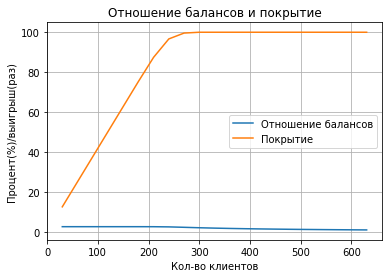

In [55]:
metr_train.sample_describe()
metr_train.plot_scores()

In [56]:
metr_valid = BalanceCover(metric_valid, target='target')
metr_valid.calc_scores(30, metric_valid.shape[0])

Всего записей в выборке:  268
Всего таргетов в выборке:  103


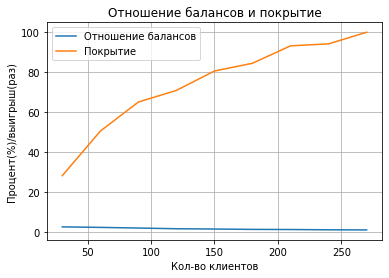

In [57]:
metr_valid.sample_describe()
metr_valid.plot_scores()

## Интерпретация модели

In [58]:
# Shap интерпретация

# задаем класс
c_shap = PlotShap(model=model_final, sample=X_train_final)
# обучаем
c_shap.fit_shap()

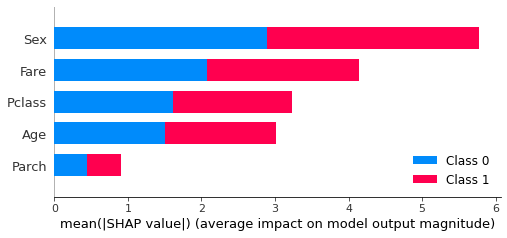

In [59]:
c_shap.create_plot_shap(plot_type='bar', number_features=30)

In [60]:
c_shap.create_shap_report(path_base='./shap_report')

Директория существует


In [61]:
# PDP-ICE интерпретация

# Задаем необходимые факторы для анализа, в нужном нам порядке
feats = features[:5]

# Задаем класс PlotPDP(model - 'наша модель', 
##                   X - 'датасет на котором обучалась модель',
##                   main_features - 'список факторов необходимых для анализа')

pdp_plot = PlotPDP(model=model_final,X=X_train_final,main_features=feats)

Sex


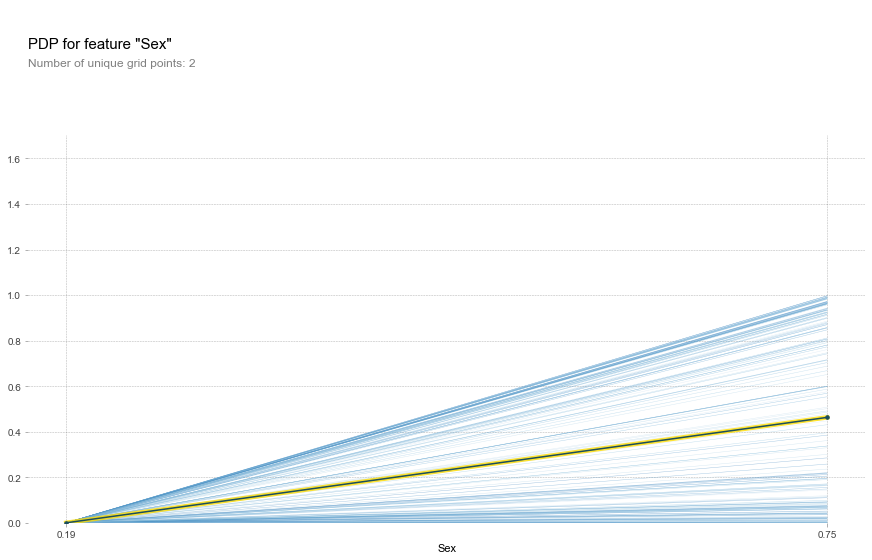

Fare


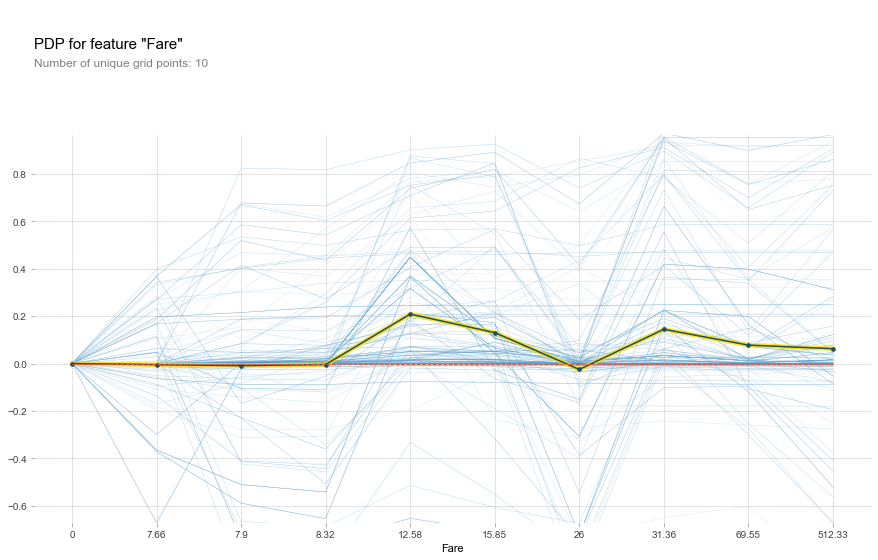

Pclass


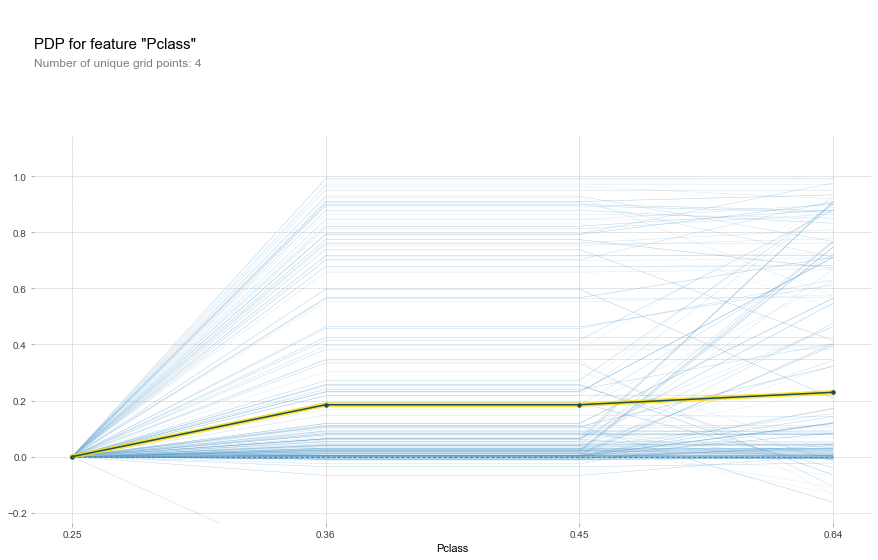

Age


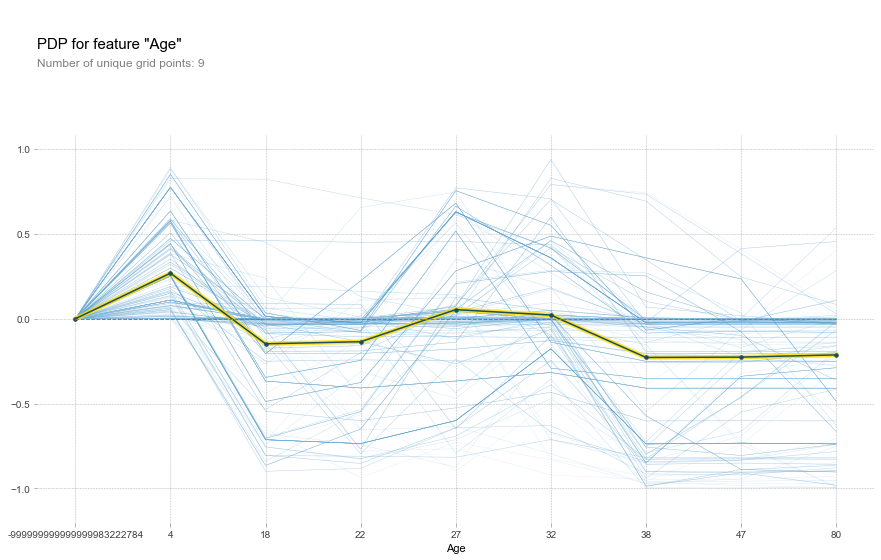

Parch


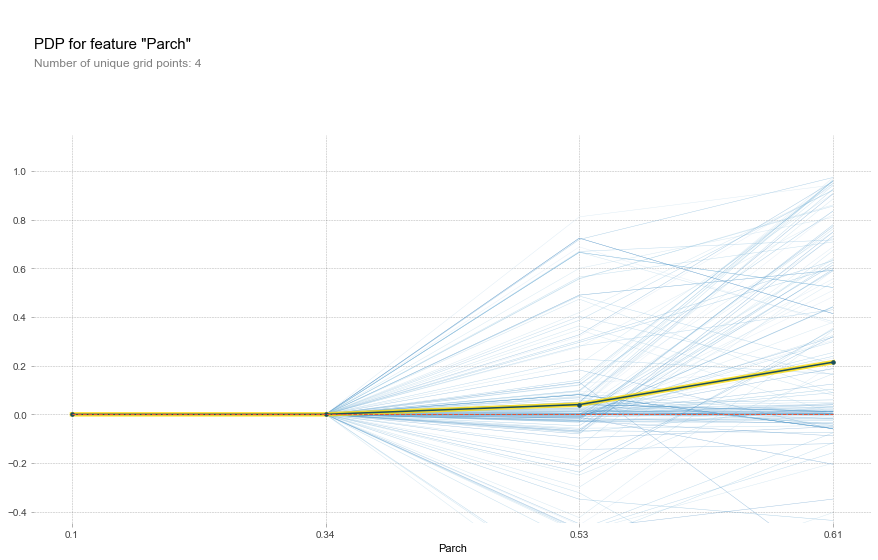

In [62]:
# Выводим графики по каждому фактору функцией create_feature_plot(save = True/False - 'Сохранить/не сохранять графики',
##                                                           frac_to_plot = 0.1 - 'доля сэмпла для анализа, по умолчанию 10%',
##                                                           n_jobs = -1,
##                                                           path = './pdp_ice_plots' - 'директория куда будут сохранены графики')

pdp_plot.create_feature_plot(save=True, frac_to_plot=0.3)

Интерпретация: Как факторы  ['Fare', 'Pclass'] совместо влияют на предсказание. Чем ярчке (желтая) ячейка, тем сильнее влияние в совокупности: Для классификации - растет вероятность отнесения к целевой метке класса; Для регрессии - растет значение предсказания. Чем темнее (фиолетовая) ячейка - обратная ситуация.


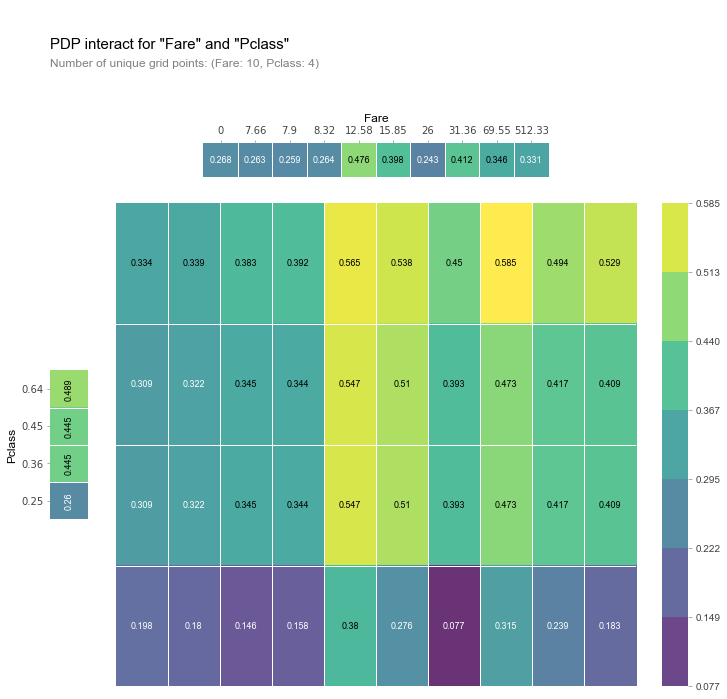

In [63]:
pdp_plot.create_interact_plot(features=['Fare','Pclass'], save=True)

In [64]:
# Генерация html отчета PDP-ICE plots функцией create_pdp_report(path_base = './pdp_ice_plots' - 'необходимая директория для графиков/отчета')

pdp_plot.create_pdp_report()

Загрузка всех сохраненных изображений 

Загрузка завершена. 

Отчет сгенерирован.
